Consumos eléctricos en el Puerto de Valencia

# Intro

## Libraries

In [1]:
import os
import glob
from datetime import datetime

import pandas as pd
import numpy as np
from decimal import Decimal
import collections
import time
import utm

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from brokenaxes import brokenaxes

from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

from functools import reduce

In [2]:
import string
import plotly
import chart_studio.plotly as py

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
import plotly.figure_factory as ff
import cufflinks as cf

In [3]:
import csv
import xlrd

In [4]:
# cufflinks offline
cf.go_offline()

In [5]:
# Run at the start of every ipython notebook to use plotly.offline. This injects the plotly.js source files into the notebook.
init_notebook_mode(connected=True)

## Input

### Files

# Analysis

## Descripción escalas

In [7]:
# en 2019

for i in buques.terminal.unique():
    for j in buques.buque_def.unique():
        print(str(i) + '  ' + str(j) + ' -- ' + 
              str(len(buques[(buques.terminal==i) & (buques.buque_def==j) & 
                             (buques['Año Servicio']==2019)])))
    print(str('TOTAL') + str(len(buques)))
    print('\n')
    

apm  contenedor -- 852
apm  roro -- 23
apm  otros -- 0
apm  ropax -- 242
apm  crucero -- 1


csp  contenedor -- 1970
csp  roro -- 0
csp  otros -- 0
csp  ropax -- 0
csp  crucero -- 0


msc  contenedor -- 857
msc  roro -- 0
msc  otros -- 0
msc  ropax -- 0
msc  crucero -- 0


vte  contenedor -- 0
vte  roro -- 716
vte  otros -- 48
vte  ropax -- 0
vte  crucero -- 0


balea_otros  contenedor -- 66
balea_otros  roro -- 0
balea_otros  otros -- 118
balea_otros  ropax -- 802
balea_otros  crucero -- 0


trasme_cru  contenedor -- 0
trasme_cru  roro -- 137
trasme_cru  otros -- 0
trasme_cru  ropax -- 369
trasme_cru  crucero -- 128


ampli_norte  contenedor -- 0
ampli_norte  roro -- 0
ampli_norte  otros -- 0
ampli_norte  ropax -- 0
ampli_norte  crucero -- 72




In [30]:
for each in buques.buque_def.unique():
    print(each)
    print(str(round(buques['Det. G.T. Buque'][buques.buque_def==each].mean(),2)) + ' GT - ' +
          str(round(buques.Potencia[buques.buque_def==each].mean(),2)) + ' kW - ' +
          str(round(buques['Amarre calculado (horas)'][buques.buque_def==each].mean(),2)) + ' h - '+
          str(round(buques.Potencia_kW[buques.buque_def==each].mean(),2)) + ' kW')
    print('\n')

contenedor
44504.04 GT - 29940.46 kW - 20.19 h - 968.68 kW


roro
34775.63 GT - 18171.79 kW - 16.82 h - 679.75 kW


otros
13275.94 GT - 6596.32 kW - 65.35 h - 1709.58 kW


ropax
23117.65 GT - 21906.0 kW - 6.63 h - 740.08 kW


crucero
73418.17 GT - 40984.29 kW - 10.49 h - 7166.8 kW




In [32]:
1970+857+852+66
242+802+369

1413

## Consumos y cobertura energética

### Descripción general

In [9]:
buques.columns

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Tipo Buque', 'Det. G.T. Buque', 'Num. Atraque', 'Power (kW)',
       'Potencia', 'Muelle Atraque Real', 'Tipo Maniobra',
       'Fecha de Fin del Servicio', 'Hora de Fin del Servicio',
       'Fecha de Inicio de Servicio', 'Hora de Inicio del Servicio',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'GT*t', 'Potencia*atraque', 'GT*atraque', 'Paux_a(kW)', 'Paux_b(kW)',
       'Paux_a*t (kWh)', 'Paux_b*t (kWh)', 'Unnamed: 25'],
      dtype='object')

In [163]:
buques[buques['Id.Escala'].duplicated()==True]

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,FH. Desamarre Calc,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25
7,2017,1 2016 6693,9326964,PASSAT,PORTACONTENEDOR,9990,3,NaN,11419,PRINCIPE FELIPE,...,2017-01-11 10:55:00,14.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2017,1 2016 6711,9619452,MSC ARICA,PORTACONTENEDOR,94017,1,NaN,64486,TRANSVERSAL COSTA,...,2017-01-02 16:25:00,9.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2017,1 2016 6713,9134139,SVEN,PORTACONTENEDOR,6362,2,NaN,2500,TRANSVERSAL COSTA,...,2017-01-05 21:10:00,8.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,2017,1 2016 6776,9246554,ALLEGRO,PORTACONTENEDOR,9962,1,NaN,11421,PRINCIPE FELIPE,...,2017-01-04 01:55:00,7.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,2017,1 2016 6799,9320439,MSC LEIGH,PORTACONTENEDOR,50963,2,NaN,54320,TRANSVERSAL COSTA,...,2017-01-05 00:10:00,11.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20008,2019,1 2019 6308,9435844,LEON,BUQUE TANQUE/MG,2997,3,NaN,3399,ESP.TUR.SUR-2,...,2019-12-05 11:50:00,24.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20009,2019,1 2019 6308,9435844,LEON,BUQUE TANQUE/MG,2997,2,NaN,3399,SUR,...,2019-12-03 21:00:00,3.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20011,2019,1 2019 6313,7827225,REGINA BALTICA,FERRYS RO/RO PASAJEROS,18345,2,NaN,25645,ESP.TUR.SUR-1,...,2019-12-10 17:55:00,18.416667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20013,2019,1 2019 6314,7827225,REGINA BALTICA,FERRYS RO/RO PASAJEROS,18345,1,NaN,25645,ESP.TUR.SUR-1,...,2019-12-12 17:30:00,7.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
print(len(buques))
print('\n')
print(len(cruceros)+len(balearia)+len(trasme)+len(cont_ihs)+len(vte)+len(otros)+len(excepciones))

20054


20012


In [181]:
buques[buques[['Id.Escala','Num. Atraque']].duplicated()==True]

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,FH. Desamarre Calc,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25


In [11]:
buques['Tipo Buque'].unique()
# buques['Muelle Atraque Real'].unique()

array(['PORTACONTENEDOR          ', 'POLIV. GENERAL CONTENEDOR',
       'MERCANT. CONVENCIONAL    ', 'RO/RO VEHÍCULO           ',
       'OTROS GRANELEROS         ', 'FERRYS RO/RO PASAJEROS   ',
       'RO/RO  LO/LO             ', 'RO/RO CARGA GENERAL      ',
       'PRODUCTOS QUÍMICOS       ', 'ASFÁLTICO                ',
       'CEMENTERO                ', 'CRUCERO TURÍSTICO        ',
       'PETROLERO REFINADO       ', 'GRANELERO/CONTENEDOR     ',
       'RO/RO CONTAINER          ', 'CEREALERO                ',
       'OTROS PORTACONTENEDORES  ', 'OTROS MERCANTES          ',
       'OTROS DE PASAJE          ', 'MERCANT. ESPECIAL        ',
       'GAS LICUADO              ', 'BUQUE TANQUE/MG          ',
       'PETROLERO NO REFINADO    ', 'OTROS BUQUES             ',
       'ACEITEROS                '], dtype=object)

In [38]:
for each in buques['Muelle Atraque Real'].unique():
        for each2 in buques['Tipo Buque'].unique():
            a =  len(buques[(buques['Muelle Atraque Real']==each) &
                            (buques['Tipo Buque']==each2)])
            if a > 0:
                print(str(each) + str(each2) + str(a))  
                
        print('\n')

LLOVERA                  PORTACONTENEDOR          662
LLOVERA                  POLIV. GENERAL CONTENEDOR18
LLOVERA                  MERCANT. CONVENCIONAL    1
LLOVERA                  OTROS MERCANTES          1


LEVANTE 1                PORTACONTENEDOR          1124
LEVANTE 1                POLIV. GENERAL CONTENEDOR76
LEVANTE 1                MERCANT. CONVENCIONAL    8
LEVANTE 1                FERRYS RO/RO PASAJEROS   25
LEVANTE 1                RO/RO  LO/LO             3
LEVANTE 1                OTROS MERCANTES          2


LEVANTE 3                PORTACONTENEDOR          426
LEVANTE 3                POLIV. GENERAL CONTENEDOR72
LEVANTE 3                MERCANT. CONVENCIONAL    7
LEVANTE 3                FERRYS RO/RO PASAJEROS   1
LEVANTE 3                OTROS MERCANTES          1


PRINCIPE FELIPE          PORTACONTENEDOR          5010
PRINCIPE FELIPE          POLIV. GENERAL CONTENEDOR240
PRINCIPE FELIPE          MERCANT. CONVENCIONAL    7
PRINCIPE FELIPE          OTROS PORTACONTEN

In [34]:
for year in buques['Año Servicio'].unique():
    print(str(year) + '\n' + '---------------------------------')
    for each in buques['Muelle Atraque Real'].unique():
        for each2 in buques['Tipo Buque'].unique():
            a =  len(buques[(buques['Muelle Atraque Real']==each) &
                            (buques['Tipo Buque']==each2) & 
                            (buques['Año Servicio']==year)])
            if a > 0:
                print(str(each) + str(each2) + str(a))
        
        print('\n')

2017
---------------------------------
LLOVERA                  PORTACONTENEDOR          262
LLOVERA                  POLIV. GENERAL CONTENEDOR4


LEVANTE 1                PORTACONTENEDOR          316
LEVANTE 1                POLIV. GENERAL CONTENEDOR29
LEVANTE 1                MERCANT. CONVENCIONAL    2
LEVANTE 1                FERRYS RO/RO PASAJEROS   24
LEVANTE 1                RO/RO  LO/LO             3


LEVANTE 3                PORTACONTENEDOR          184
LEVANTE 3                POLIV. GENERAL CONTENEDOR32
LEVANTE 3                MERCANT. CONVENCIONAL    2
LEVANTE 3                FERRYS RO/RO PASAJEROS   1


PRINCIPE FELIPE          PORTACONTENEDOR          1971
PRINCIPE FELIPE          POLIV. GENERAL CONTENEDOR98
PRINCIPE FELIPE          MERCANT. CONVENCIONAL    3
PRINCIPE FELIPE          OTROS PORTACONTENEDORES  2
PRINCIPE FELIPE          MERCANT. ESPECIAL        2


LEVANTE 2                PORTACONTENEDOR          100
LEVANTE 2                POLIV. GENERAL CONTENEDOR33
L



TRANSVERSALES            FERRYS RO/RO PASAJEROS   25
TRANSVERSALES            RO/RO  LO/LO             287
TRANSVERSALES            CRUCERO TURÍSTICO        34


TRANSV. DIQUE DEL ESTE   RO/RO VEHÍCULO           68
TRANSV. DIQUE DEL ESTE   RO/RO CARGA GENERAL      72


ESP.TUR.TESTERO          POLIV. GENERAL CONTENEDOR1
ESP.TUR.TESTERO          MERCANT. CONVENCIONAL    3
ESP.TUR.TESTERO          OTROS GRANELEROS         4
ESP.TUR.TESTERO          CEMENTERO                15
ESP.TUR.TESTERO          GRANELERO/CONTENEDOR     2


PONIENTE-2               FERRYS RO/RO PASAJEROS   1
PONIENTE-2               CRUCERO TURÍSTICO        22


CRUCEROS DOS             CRUCERO TURÍSTICO        58
CRUCEROS DOS             BUQUE TANQUE/MG          1


M. ESTE (PRINCIPE FELIPE)PORTACONTENEDOR          100
M. ESTE (PRINCIPE FELIPE)POLIV. GENERAL CONTENEDOR9


CRUCEROS UNO             PORTACONTENEDOR          4
CRUCEROS UNO             CRUCERO TURÍSTICO        15
CRUCEROS UNO             OTROS BUQUES 

In [22]:
# Conversión del Ciudad de Ibiza de RoRo a RoPax
buques['Tipo Buque'][buques.Buque=='CIUDAD DE IBIZA     '] = 'FERRYS RO/RO PASAJEROS   '

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
# definición tipo buque y clasificación 
buques['buque_def'] = ""

# contenedor
buques['buque_def'][buques['Tipo Buque'].isin(['PORTACONTENEDOR          ', 'POLIV. GENERAL CONTENEDOR',
                                               'MERCANT. CONVENCIONAL    ', 'OTROS PORTACONTENEDORES  ',
                                               'OTROS MERCANTES          ', 'MERCANT. ESPECIAL        ',])] = 'contenedor'     
# cruceros
buques['buque_def'][buques['Tipo Buque'].isin(['CRUCERO TURÍSTICO        '])] = 'crucero'

# ropax
buques['buque_def'][buques['Tipo Buque'].isin(['FERRYS RO/RO PASAJEROS   ','OTROS DE PASAJE          '])] = 'ropax'

# roro
buques['buque_def'][buques['Tipo Buque'].isin(['RO/RO  LO/LO             ', 'RO/RO CARGA GENERAL      ',
                                                 'RO/RO VEHÍCULO           ', 'RO/RO CONTAINER          '])] = 'roro'

# otros
buques['buque_def'][buques['Tipo Buque'].isin(['OTROS GRANELEROS         ', 'PRODUCTOS QUÍMICOS       ', 
                                               'ASFÁLTICO                ', 'CEMENTERO                ',
                                               'PETROLERO REFINADO       ', 'GRANELERO/CONTENEDOR     ',
                                               'GAS LICUADO              ', 'BUQUE TANQUE/MG          ',
                                               'PETROLERO NO REFINADO    ', 'OTROS BUQUES             ',
                                               'ACEITEROS                ', 'CEREALERO                '])] = 'otros'
                                               

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [7]:
# definición terminales y clasificación 
buques['terminal'] = ""

# apm
buques['terminal'][buques['Muelle Atraque Real'].isin(['LLOVERA                  ', 'LEVANTE 1                ',
                                                 'LEVANTE 2                ', 'LEVANTE 3                ',
                                                 'LEVANTE 4                '])] = 'apm'
# csp
buques['terminal'][buques['Muelle Atraque Real'].isin(['PRINCIPE FELIPE          ', 'MUELLE DE COSTA          ',
                                                 'M. ESTE (PRINCIPE FELIPE)'])] = 'csp'
# msc
buques['terminal'][buques['Muelle Atraque Real'].isin(['TRANSVERSAL COSTA        '])] = 'msc'

# balearia y otros
buques['terminal'][buques['Muelle Atraque Real'].isin(['SUR                      ', 'TURIA                    ',
                                                              'ESP.TUR.SUR-1            ', 'ESP.TUR.SUR-2            ',
                                                              'ESP.TUR.NORTE-1          ', 'ESP.TUR.NORTE-2          ',
                                                              'ESP.TUR.TESTERO          '])] = 'balea_otros'
# vte
buques['terminal'][buques['Muelle Atraque Real'].isin(['DIQUE DEL ESTE           ', 'TRANSV. DIQUE DEL ESTE   ',
                                                       'NORTE(XITA)              '])] = 'vte'
# trasme y cruceros
buques['terminal'][buques['Muelle Atraque Real'].isin(['PONIENTE-1               ', 'PONIENTE-2               ',
                                                              'TRANSVERSALES            '])] = 'trasme_cru'
#ampli_norte
buques['terminal'][buques['Muelle Atraque Real'].isin(['CRUCEROS UNO             ', 'CRUCEROS DOS             ',
                                                         'CRUCEROS TRES            '])] = 'ampli_norte'


C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [37]:
for each in buques.terminal.unique():
    for each2 in buques.buque_def.unique():
        a =  len(buques[(buques.terminal==each) &
                            (buques.buque_def==each2)])
                        
        print(str(each) + ' / ' + str(each2)+ '    '+ str(a))
    print('\n')

apm contenedor 2921
apm roro 104
apm otros 0
apm ropax 644
apm crucero 1


csp contenedor 6179
csp roro 0
csp otros 0
csp ropax 0
csp crucero 0


msc contenedor 2483
msc roro 0
msc otros 0
msc ropax 0
msc crucero 0


vte contenedor 1
vte roro 2201
vte otros 138
vte ropax 0
vte crucero 0


balea_otros contenedor 196
balea_otros roro 0
balea_otros otros 344
balea_otros ropax 2490
balea_otros crucero 0


trasme_cru contenedor 0
trasme_cru roro 305
trasme_cru otros 0
trasme_cru ropax 1241
trasme_cru crucero 389


ampli_norte contenedor 0
ampli_norte roro 0
ampli_norte otros 0
ampli_norte ropax 0
ampli_norte crucero 208




In [46]:
buques.groupby('buque_def').mean()

,Año Servicio,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25
buque_def,,,,,,,,,,,,,,,,
contenedor,2017.971307,44478.402207,1.351783,NaN,36363.793379,1156.725722,1140.005942,20.188473,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN
crucero,2017.996656,73418.469900,1.010033,NaN,49035.322742,833.871237,798.913043,10.490942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
otros,2018.031120,13275.943983,1.159751,NaN,6542.134855,1205.966805,1196.141079,65.351383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ropax,2017.979429,23212.776914,1.030400,NaN,28554.372114,1761.756571,1738.770286,6.627848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
roro,2017.999234,34775.625287,1.050958,NaN,20043.924904,1166.650192,1146.986207,16.821737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
for each in buques.buque_def.unique():
    print(str(each) + '    ' + str(buques[buques.buque_def == each].Potencia_kW.mean()))

contenedor    958.9796079301392
roro    500.0
otros    1688.8036016597518
ropax    740.0821194093887
crucero    8460.126734113726


In [16]:
len(buques[buques.buque_def == 'contenedor'].drop_duplicates(subset='Clave Lloyd o Num. OMI'))
len(buques.drop_duplicates(subset='Clave Lloyd o Num. OMI'))

1644

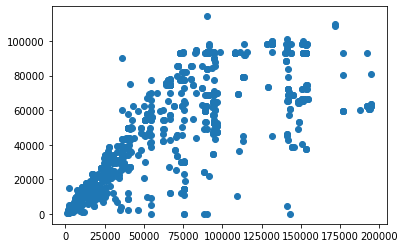

In [14]:
# GT_cont = 
gt = buques[buques.buque_def == 'contenedor'].drop_duplicates(subset='Clave Lloyd o Num. OMI')['Det. G.T. Buque']
pot =buques[buques.buque_def == 'contenedor'].drop_duplicates(subset='Clave Lloyd o Num. OMI').Potencia

plt.scatter(gt,pot)

del gt
del pot

### Merging (outdated)

In [219]:
#concatenar las potencias de todas las hojas de excel por separado

frames = [cont_ihs[['Id.Escala','Num. Atraque','Potencia_kW']], cruceros[['Id.Escala','Num. Atraque','Potencia_kW']],
          trasme[['Id.Escala','Num. Atraque','Potencia_kW']], balearia[['Id.Escala','Num. Atraque','Potencia_kW']],
          vte[['Id.Escala','Num. Atraque','Potencia_kW']], otros[['Id.Escala','Num. Atraque','Potencia_kW']]]

result = pd.concat(frames, ignore_index=True)

In [222]:
result.describe(include='all')

,Id.Escala,Num. Atraque,Potencia_kW
count,19845,19845.000000,19846.000000
unique,17547,NaN,776.000000
top,1 2018 2676,NaN,313.396775
freq,4,NaN,3972.000000
mean,NaN,1.226405,NaN
std,NaN,0.540804,NaN
min,NaN,1.000000,NaN
25%,NaN,1.000000,NaN
50%,NaN,1.000000,NaN
75%,NaN,1.000000,NaN


In [226]:
# merge

buques = pd.merge(buques,result, on=['Id.Escala','Num. Atraque'] , how='left')

In [237]:
# drop excepciones y errores

buques = buques[buques['Potencia_kW'].notna()]

In [227]:
len(buques.columns)

27

In [230]:
len(buques.Potencia_kW)

20056

In [235]:
# faltan 211 escalas, que corresponden a excepciones y errores en el Excel
buques[buques.Potencia_kW.notna()==False]

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,Potencia_kW
37,2017,1 2016 6826,9084607,MSC NITA,PORTACONTENEDOR,15859,2,NaN,16800,NORTE(XITA),...,130.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,2017,1 2017 29,9282259,MSC ELA,PORTACONTENEDOR,54304,2,NaN,55889,CRUCEROS TRES,...,20.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
334,2017,1 2017 277,9619464,MSC AGADIR,PORTACONTENEDOR,94017,4,NaN,64486,CRUCEROS TRES,...,63.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
385,2017,1 2017 330,9327580,KARIN S,PORTACONTENEDOR,9957,4,NaN,13229,CRUCEROS TRES,...,45.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,2017,1 2017 345,8401145,MAESTRO SEA,RO/RO VEHÍCULO,15375,1,NaN,5873,ESP.TUR.SUR-1,...,27.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20029,2019,1 2019 6368,9304631,CIUDAD DE CADIZ,FERRYS RO/RO PASAJEROS,26302,2,NaN,3600,DIQUE DEL ESTE,...,54.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20034,2019,1 2019 6377,9403437,VEGA AZURIT,PORTACONTENEDOR,9957,1,NaN,9730,TRANSVERSAL COSTA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20044,2019,1 2019 6404,9304631,VENEZIA,FERRYS RO/RO PASAJEROS,26302,3,NaN,3600,DIQUE DEL ESTE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20052,2019,1 2019 6450,9435844,LEON,BUQUE TANQUE/MG,2997,2,NaN,3399,ESP.TUR.SUR-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [224]:
buques = buques.drop(['Potencia_kW_x','Potencia_kW_y'],axis=1)

In [244]:
buques['Amarre calculado (horas)'].mean()

17.56083312337544

In [240]:
buques.describe(include='all')

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,Potencia_kW
count,19845.000000,19845,19845,19845,19845,19845.000000,19845.000000,0.0,19845.000000,19845,...,19845.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,19845.000000
unique,NaN,17547,1644,1703,25,NaN,NaN,NaN,NaN,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,776.000000
top,NaN,1 2018 2676,9498743,FORZA,PORTACONTENEDOR,NaN,NaN,NaN,NaN,PRINCIPE FELIPE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313.396775
freq,NaN,4,828,807,10908,NaN,NaN,NaN,NaN,5257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3972.000000
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2017.978987,NaN,NaN,NaN,NaN,38628.324969,1.226405,NaN,32153.284958,NaN,...,17.560833,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,NaN
std,0.815907,NaN,NaN,NaN,NaN,34619.718435,0.540804,NaN,25175.980617,NaN,...,18.577895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2017.000000,NaN,NaN,NaN,NaN,682.000000,1.000000,NaN,1.000000,NaN,...,0.166667,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,NaN
25%,2017.000000,NaN,NaN,NaN,NaN,16686.000000,1.000000,NaN,13229.000000,NaN,...,8.083333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,NaN


### Consumo total por muelle

In [ ]:
# totales hotelling (por muelle)

for i in buques['Año Servicio'].unique():
    for j in buques['Muelle Atraque Real'].unique():
        print( str(i) + '  ' + str(j) + ' -- ' +
               str(round(((buques.Potencia_kW[(buques['Año Servicio']==i) & 
                                                     (buques['Muelle Atraque Real']== str(j))])*(
                   buques['Amarre calculado (horas)'][(buques['Año Servicio']==i) & 
                                                     (buques['Muelle Atraque Real']== str(j))])).sum()/1e6,2))
               + " GWh")
    print('\n')
    print(str(i) + '   ' +  
          str(round(((buques.Potencia_kW[buques['Año Servicio']==i])*(
                      buques['Amarre calculado (horas)'][buques['Año Servicio']==i])).sum()/1e6,2)) +
          " GWh")
    print('\n')

### Consumo total por tipo de buque

In [8]:
# totales hotelling (por tipo buque)

for i in buques['Año Servicio'].unique():
    for j in buques.buque_def.unique():
        print( str(i) + '  ' + str(j) + ' -- ' +
               str(round(((buques.Potencia_kW[(buques['Año Servicio']==i) & 
                                                     (buques.buque_def== str(j))])*(
                   buques['Amarre calculado (horas)'][(buques['Año Servicio']==i) & 
                                                     (buques.buque_def== str(j))])).sum()/1e6,2))
               + " GWh")
    print('\n')
    print(str(i) + '   ' +  
          str(round(((buques.Potencia_kW[buques['Año Servicio']==i])*(
                      buques['Amarre calculado (horas)'][buques['Año Servicio']==i])).sum()/1e6,2)) +
          " GWh")
    print('\n')

2017  contenedor -- 84.89 GWh
2017  roro -- 7.84 GWh
2017  otros -- 13.78 GWh
2017  ropax -- 6.67 GWh
2017  crucero -- 18.87 GWh


2017   132.05 GWh


2018  contenedor -- 86.36 GWh
2018  roro -- 7.13 GWh
2018  otros -- 13.91 GWh
2018  ropax -- 6.3 GWh
2018  crucero -- 16.32 GWh


2018   130.03 GWh


2019  contenedor -- 87.81 GWh
2019  roro -- 6.98 GWh
2019  otros -- 14.87 GWh
2019  ropax -- 6.39 GWh
2019  crucero -- 16.62 GWh


2019   132.67 GWh




### Simultaneidad

#### Total

In [9]:
dfIN = buques[['FH. Amarre Calc','Potencia_kW']]
dfOUT = buques[['FH. Desamarre Calc','Potencia_kW']]
dfIN['direction'] = 1
dfOUT['direction'] = -1

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
dfIN.columns = ('TS','pot_media','direction')
dfOUT.columns = ('TS','pot_media','direction')

In [15]:
traffic_buques = pd.concat([dfIN, dfOUT]).sort_values('TS')

In [16]:
traffic_buques.pot_media = traffic_buques.pot_media*traffic_buques.direction

In [17]:
traffic_buques['ships'] = traffic_buques['direction'].cumsum()
traffic_buques['cum_pot'] = traffic_buques['pot_media'].cumsum()

In [18]:
traffic_buques = traffic_buques.round()

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



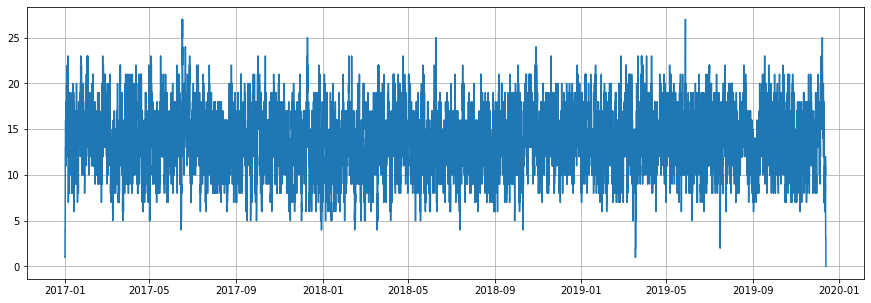

In [25]:
plt.figure(figsize=(15,5))

plt.step(traffic_buques.TS,traffic_buques.ships, where='post')
plt.grid(True)
# plt.xlim(['2018-01-01','2019-01-01'])
# plt.xlim(['2018-09-24 00','2018-09-24 12'])


In [26]:
traffic_buques.ships.tail()

19794    4
19824    3
19653    2
19698    1
19728    0
Name: ships, dtype: int64

In [27]:
traffic_buques.TS.astype('datetime64')

40      2017-01-01 14:30:00
17      2017-01-01 15:05:00
5       2017-01-01 16:30:00
2       2017-01-01 17:50:00
8       2017-01-01 21:00:00
                ...        
19794   2019-12-13 01:45:00
19824   2019-12-13 02:15:00
19653   2019-12-13 08:00:00
19698   2019-12-13 09:05:00
19728   2019-12-13 10:05:00
Name: TS, Length: 39690, dtype: datetime64[ns]

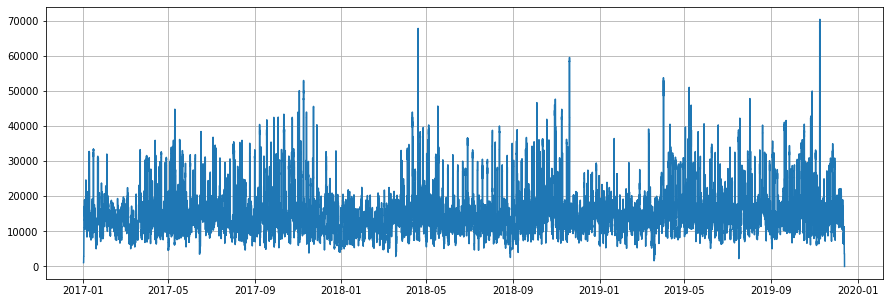

In [29]:
plt.figure(figsize=(15,5))

plt.step(traffic_buques.TS,traffic_buques.cum_pot, where='post')
plt.grid(True)
# plt.xlim(['2018-01-01','2019-01-01'])

# plt.xlim(['2019-01-01','2019-12-13'])
# plt.xlim(['2017-01-20 18','2017-01-20 22'])
# plt.ylim([10000,30000])

In [30]:
# milisegundos para evitar duplicados en las time series

traffic_buques.TS = traffic_buques.TS.astype('datetime64')+pd.to_timedelta(traffic_buques.groupby('TS').cumcount(), unit='ms')

In [31]:
traffic_buques.TS.is_unique

True

In [32]:
print(len(traffic_buques[traffic_buques.TS.duplicated()==True]))

0


In [33]:
traffic_buques = traffic_buques.set_index('TS')#.resample('h')

In [34]:
### ---------------------------------------------------------- ###
### función que da el valor acumulado de potencias por horas
### ---------------------------------------------------------- ###

traffic_buques.resample('1H').ffill().fillna(0).head(10)#.groupby('TS').sum()

,pot_media,direction,ships,cum_pot
TS,,,,
2017-01-01 14:00:00,0.000000,0.0,0.0,0.000000
2017-01-01 15:00:00,1069.380000,1.0,1.0,1069.380000
2017-01-01 16:00:00,313.396775,1.0,2.0,1382.776775
2017-01-01 17:00:00,313.396775,1.0,3.0,1696.173550
2017-01-01 18:00:00,1187.463743,1.0,4.0,2883.637292
2017-01-01 19:00:00,1187.463743,1.0,4.0,2883.637292
2017-01-01 20:00:00,1187.463743,1.0,4.0,2883.637292
2017-01-01 21:00:00,1679.538758,1.0,5.0,4563.176050
2017-01-01 22:00:00,500.000000,1.0,7.0,6713.470824


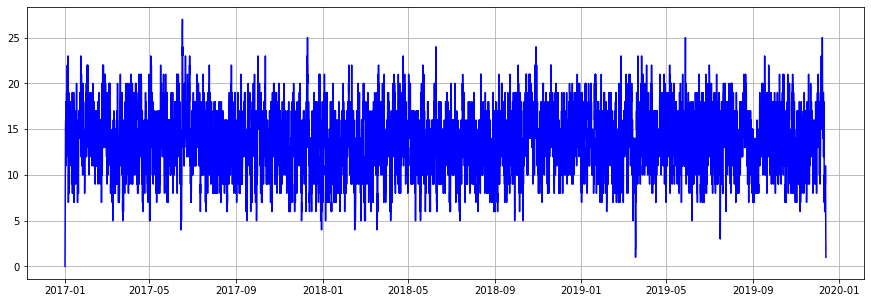

In [36]:
plt.figure(figsize=(15,5))

x = traffic_buques.resample('1H').ffill().index
y = traffic_buques.resample('1H').ffill().fillna(0).ships

plt.plot(x,y,'b')
plt.grid(True)
# plt.xlim(['2019-12-10','2019-12-13'])
# plt.xlim(['2019-01-01','2019-12-13'])

(array([0.00086493, 0.03300414, 0.11256729, 0.05099725, 0.00184108]),
 array([-0.5,  5.5, 10.5, 15.5, 20.5, 27. ]),
 <a list of 5 Patch objects>)

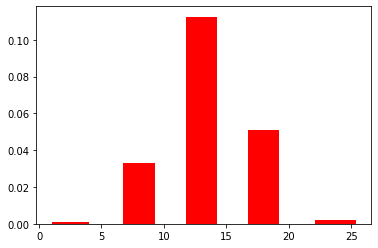

In [37]:
x = traffic_buques.resample('1H').ffill().fillna(0).ships

plt.hist(x=x,bins=[-0.5, 5.5, 10.5, 15.5, 20.5, 27],density=True, rwidth=0.5, color='r')
# plt.grid(True)

(737060.0, 737406.0)

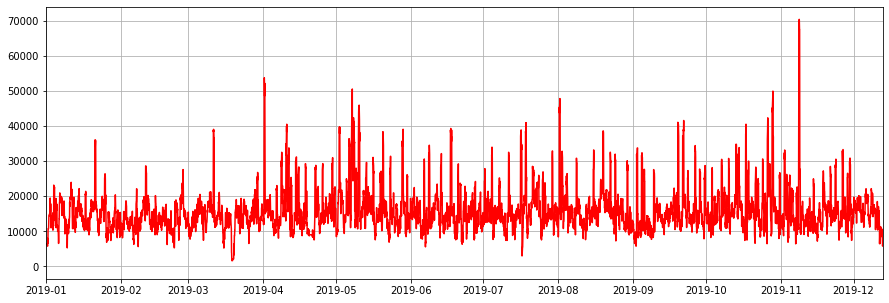

In [38]:
plt.figure(figsize=(15,5))

x = traffic_buques.resample('1H').ffill().index
y = traffic_buques.resample('1H').ffill().fillna(0).cum_pot

plt.plot(x,y,'r')
plt.grid(True)
plt.xlim(['2019-12-10','2019-12-13'])
plt.xlim(['2019-01-01','2019-12-13'])

In [39]:
sim = pd.concat([traffic_buques.resample('1H').ffill().fillna(0).ships,
                 traffic_buques.resample('1H').ffill().fillna(0).cum_pot], axis=1)


In [40]:
sim2017 = sim[sim.index.year == 2017]
sim2017.sort_values(by='cum_pot', inplace=True)
sim2017.cum_pot = sim2017.cum_pot/1000
sim2017['int'] = range(1,len(sim2017)+1)
sim2017['percent'] = sim2017.int*100/len(sim2017)
sim2017.reset_index(inplace=True)
    
sim2018 = sim[sim.index.year == 2018]
sim2018.sort_values(by='cum_pot', inplace=True)
sim2018.cum_pot = sim2018.cum_pot/1000
sim2018['int'] = range(1,len(sim2018)+1)
sim2018['percent'] = sim2018.int*100/len(sim2018)
sim2018.reset_index(inplace=True)
    
sim2019 = sim[sim.index.year == 2019]
sim2019.sort_values(by='cum_pot', inplace=True)
sim2019.cum_pot = sim2019.cum_pot/1000
sim2019['int'] = range(1,len(sim2019)+1)
sim2019['percent'] = sim2019.int*100/len(sim2019)
sim2019.reset_index(inplace=True)
    
sim = pd.concat([sim2017,sim2018,sim2019], axis=1)

In [41]:
sim.to_excel("sim_buques.xlsx")

(array([3.400e+01, 4.510e+02, 3.071e+03, 7.370e+03, 7.757e+03, 3.705e+03,
        1.055e+03, 5.610e+02, 6.220e+02, 5.380e+02, 2.870e+02, 1.600e+02,
        8.300e+01, 5.500e+01, 3.400e+01, 1.600e+01, 2.000e+00, 8.000e+00,
        9.000e+00, 3.000e+00]),
 array([    0.        ,  3281.86614073,  6563.73228146,  9845.59842218,
        13127.46456291, 16409.33070364, 19691.19684437, 22973.0629851 ,
        26254.92912583, 29536.79526655, 32818.66140728, 36100.52754801,
        39382.39368874, 42664.25982947, 45946.1259702 , 49227.99211092,
        52509.85825165, 55791.72439238, 59073.59053311, 62355.45667384,
        65637.32281457]),
 <a list of 20 Patch objects>)

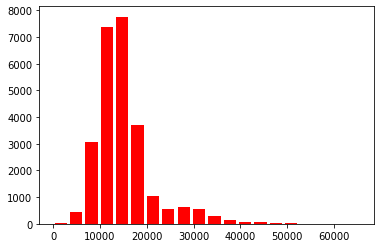

In [58]:
x = traffic_buques.resample('1H').ffill().fillna(0).cum_pot

plt.hist(x=x,bins=20, rwidth= 0.8, color='r')
# plt.grid(True)

#### Por terminal

In [45]:
path = r'C:\Users\badria\OneDrive - FUNDACIÓN VALENCIAPORT\Plan 0 emisiones 2030'

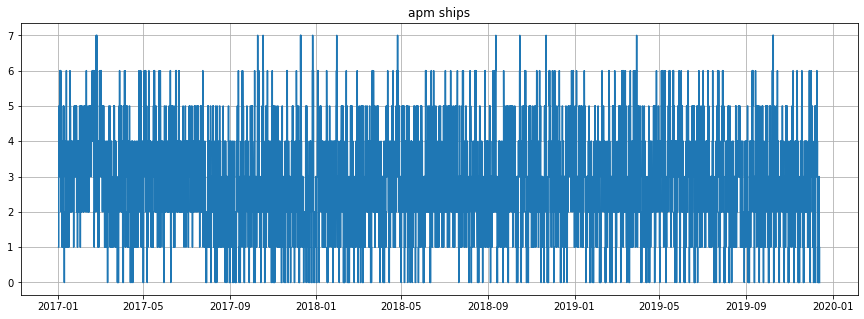

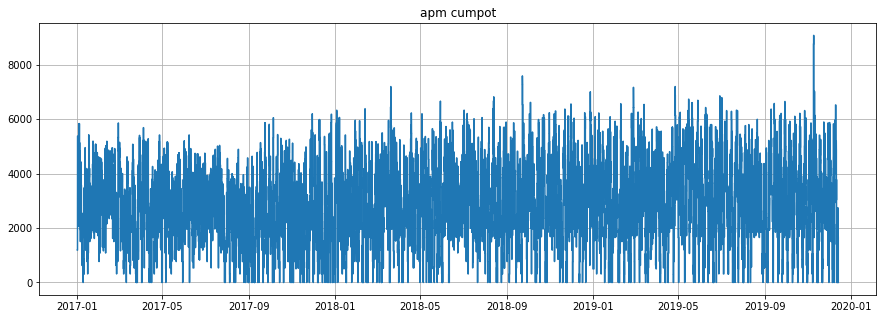

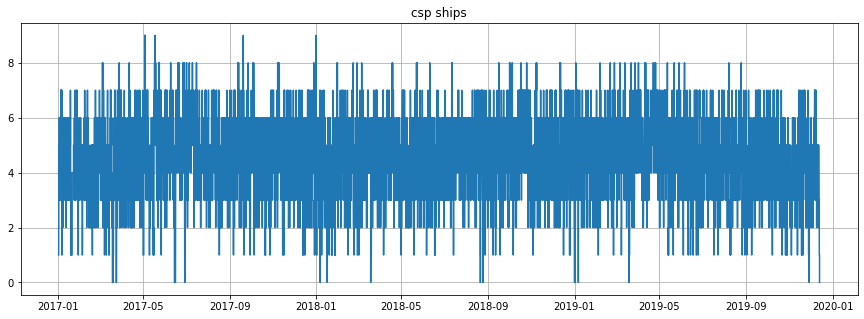

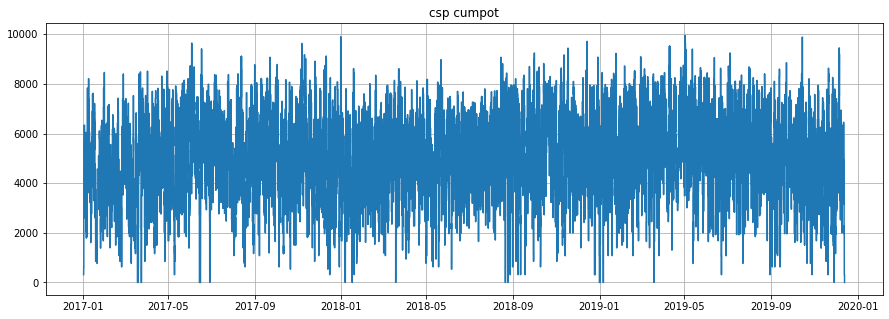

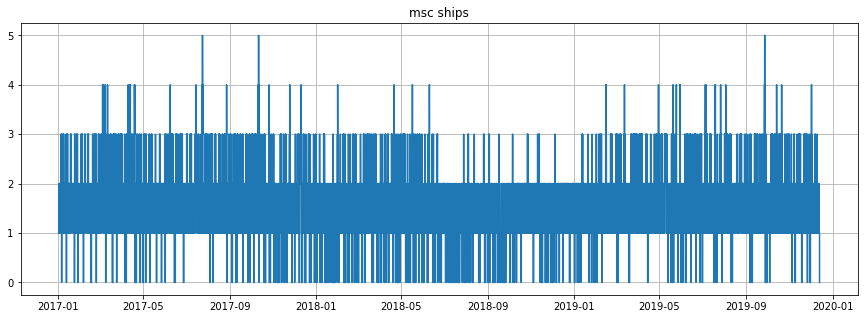

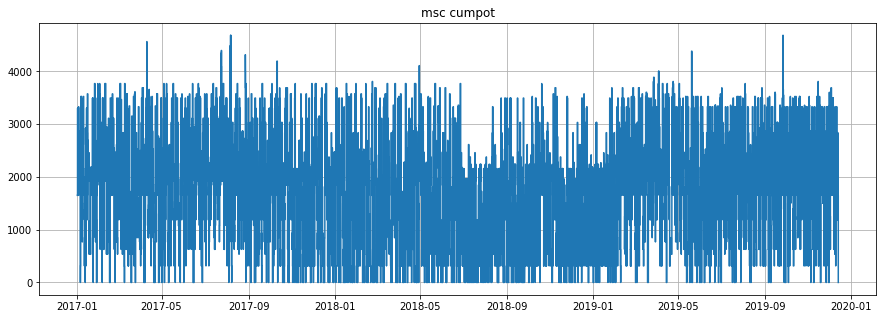

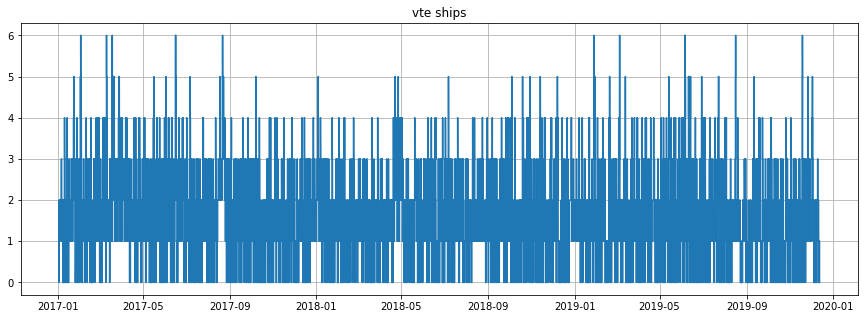

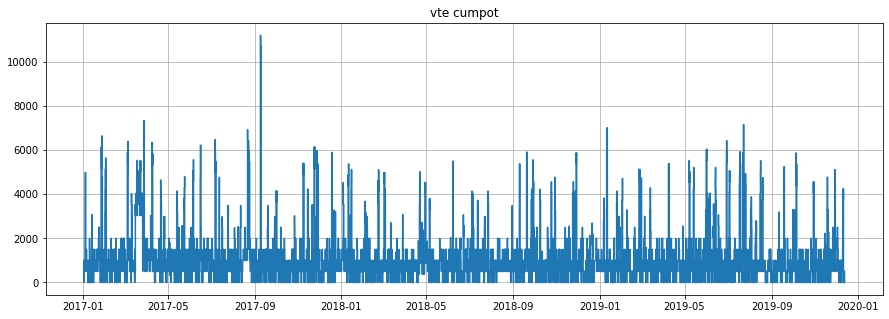

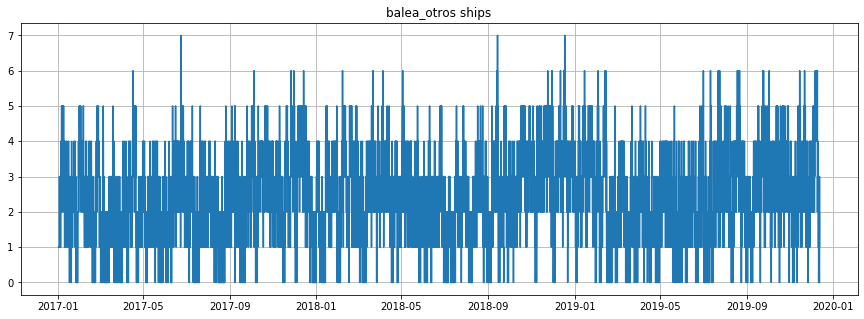

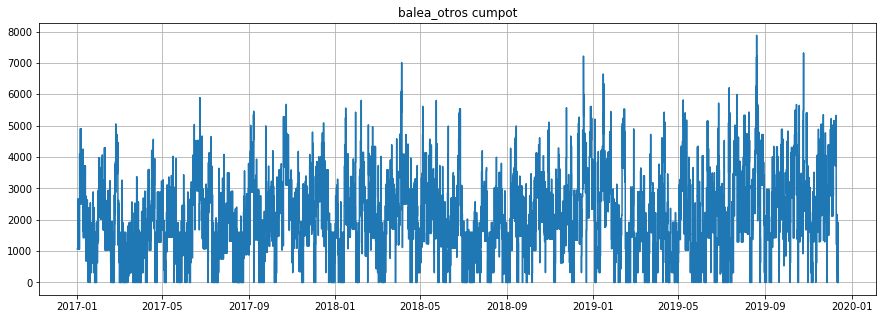

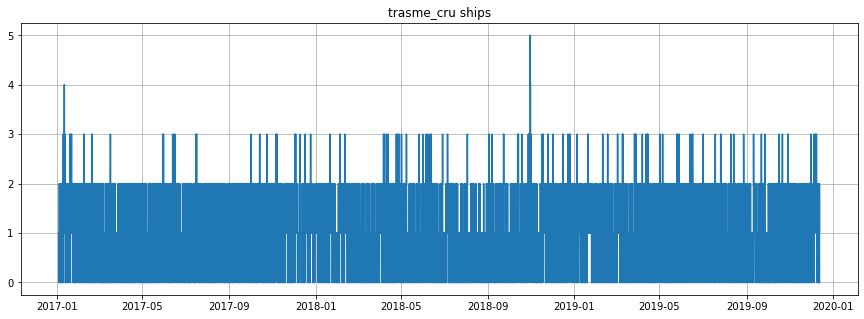

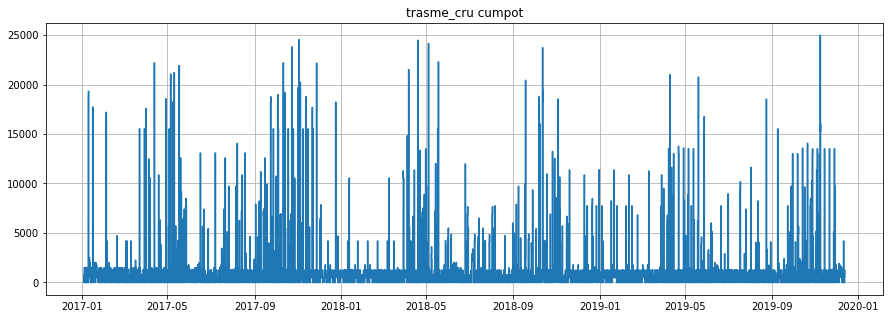

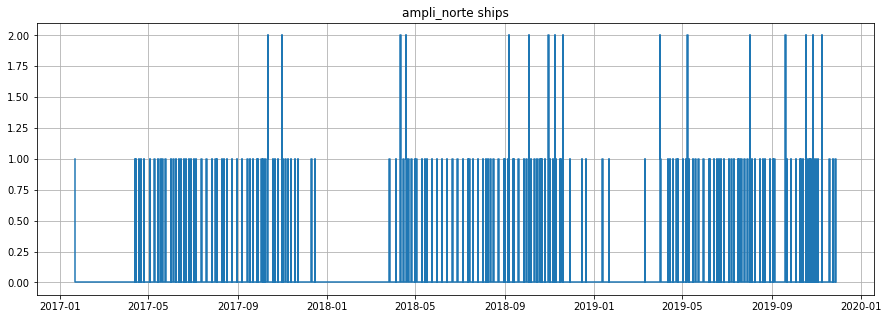

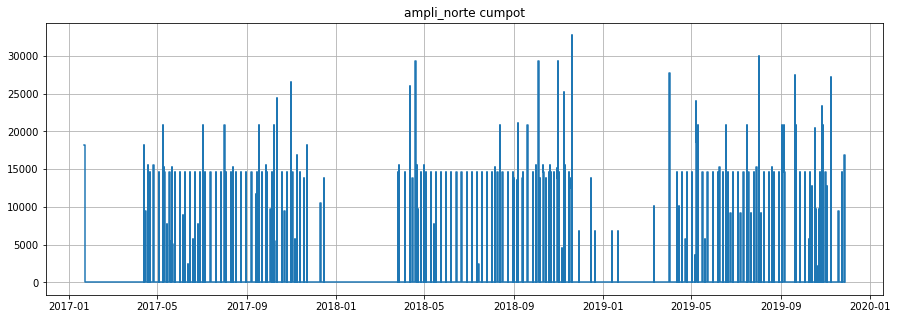

In [46]:
writer = pd.ExcelWriter(path + '\simultaneidad/output.xlsx',engine='xlsxwriter')

for each in buques.terminal.unique():
#     each = pd.DataFrame(each)
    dfIN = buques[buques.terminal==each][['FH. Amarre Calc','Potencia_kW']]
    dfOUT = buques[buques.terminal==each][['FH. Desamarre Calc','Potencia_kW']]
    dfIN['direction'] = 1
    dfOUT['direction'] = -1
    dfIN.columns = ('TS','pot_media','direction')
    dfOUT.columns = ('TS','pot_media','direction')
    
    traffic_buques = pd.concat([dfIN, dfOUT]).sort_values('TS')
    traffic_buques.pot_media = traffic_buques.pot_media*traffic_buques.direction
    traffic_buques['ships'] = traffic_buques['direction'].cumsum()
    traffic_buques['cum_pot'] = traffic_buques['pot_media'].cumsum()
    traffic_buques = traffic_buques.round()
    
    # plots de buques simultaneos y potencia acumulada
    plt.figure(figsize=(15,5))
    plt.step(traffic_buques.TS,traffic_buques.ships, where='post')
    plt.grid(True)
    plt.title(each + ' ships')
    plt.savefig(path + '\simultaneidad\simplots/' + each + '_ships.png', format="PNG")

    plt.figure(figsize=(15,5))
    plt.step(traffic_buques.TS,traffic_buques.cum_pot, where='post')
    plt.grid(True)
    plt.title( each + ' cumpot')
    plt.savefig(path + '\simultaneidad\simplots/' + each + '_cumpot.png', format="PNG")

    # milisegundos para evitar duplicados en las time series
    traffic_buques.TS = traffic_buques.TS.astype('datetime64')+pd.to_timedelta(traffic_buques.groupby('TS').cumcount(), unit='ms')
    
    traffic_buques = traffic_buques.set_index('TS')
    
    sim = pd.concat([traffic_buques.resample('1H').ffill().fillna(0).ships,
                     traffic_buques.resample('1H').ffill().fillna(0).cum_pot], axis=1)
    
    sim2017 = sim[sim.index.year == 2017]
    sim2017.sort_values(by='cum_pot', inplace=True)
    sim2017.cum_pot = sim2017.cum_pot/1000
    sim2017['int'] = range(1,len(sim2017)+1)
    sim2017['percent'] = sim2017.int*100/len(sim2017)
    sim2017.reset_index(inplace=True)
    
    sim2018 = sim[sim.index.year == 2018]
    sim2018.sort_values(by='cum_pot', inplace=True)
    sim2018.cum_pot = sim2018.cum_pot/1000
    sim2018['int'] = range(1,len(sim2018)+1)
    sim2018['percent'] = sim2018.int*100/len(sim2018)
    sim2018.reset_index(inplace=True)
    
    sim2019 = sim[sim.index.year == 2019]
    sim2019.sort_values(by='cum_pot', inplace=True)
    sim2019.cum_pot = sim2019.cum_pot/1000
    sim2019['int'] = range(1,len(sim2019)+1)
    sim2019['percent'] = sim2019.int*100/len(sim2019)
    sim2019.reset_index(inplace=True)
    
    sim = pd.concat([sim2017,sim2018,sim2019], axis=1)
    
    sim.to_excel(writer,sheet_name=each)
writer.save()
writer.close()

#### Por terminal (outdated)

In [61]:
buques['Muelle Atraque Real'].unique()

array(['LLOVERA                  ', 'LEVANTE 1                ',
       'LEVANTE 3                ', 'PRINCIPE FELIPE          ',
       'LEVANTE 2                ', 'TRANSVERSAL COSTA        ',
       'LEVANTE 4                ', 'DIQUE DEL ESTE           ',
       'SUR                      ', 'TURIA                    ',
       'ESP.TUR.SUR-1            ', 'ESP.TUR.SUR-2            ',
       'PONIENTE-1               ', 'TRANSVERSALES            ',
       'NORTE(XITA)              ', 'TRANSV. DIQUE DEL ESTE   ',
       'ESP.TUR.TESTERO          ', 'PONIENTE-2               ',
       'CRUCEROS DOS             ', 'M. ESTE (PRINCIPE FELIPE)',
       'CRUCEROS UNO             ', 'ESP.TUR.NORTE-1          ',
       'ESP.TUR.NORTE-2          ', 'MUELLE DE COSTA          ',
       'CRUCEROS TRES            '], dtype=object)

In [66]:
# definición terminales

apm = buques[buques['Muelle Atraque Real'].isin(['LLOVERA                  ', 'LEVANTE 1                ',
                                                 'LEVANTE 2                ', 'LEVANTE 3                ',
                                                 'LEVANTE 4                '])]

csp = buques[buques['Muelle Atraque Real'].isin(['PRINCIPE FELIPE          ', 'MUELLE DE COSTA          ',
                                                 'M. ESTE (PRINCIPE FELIPE)'])]

msc = buques[buques['Muelle Atraque Real'].isin(['TRANSVERSAL COSTA        '])]

Tpax_balea_otros = buques[buques['Muelle Atraque Real'].isin(['SUR                      ', 'TURIA                    ',
                                                              'ESP.TUR.SUR-1            ', 'ESP.TUR.SUR-2            ',
                                                              'ESP.TUR.NORTE-1          ', 'ESP.TUR.NORTE-2          ',
                                                              'ESP.TUR.TESTERO          '])]

Tauto_vte = buques[buques['Muelle Atraque Real'].isin(['DIQUE DEL ESTE           ', 'TRANSV. DIQUE DEL ESTE   ',
                                                       'NORTE(XITA)              '])]

Tpax_trasme_cruc = buques[buques['Muelle Atraque Real'].isin(['PONIENTE-1               ', 'PONIENTE-2               ',
                                                              'TRANSVERSALES            '])]

ampli_norte = buques[buques['Muelle Atraque Real'].isin(['CRUCEROS UNO             ', 'CRUCEROS DOS             ',
                                                         'CRUCEROS TRES            '])]

In [107]:
terminales = [apm, csp, msc, Tpax_balea_otros, Tauto_vte, Tpax_trasme_cruc, ampli_norte]
terminales_str = ['apm', 'csp', 'msc', 'Tpax_balea_otros', 'Tauto_vte', 'Tpax_trasme_cruc', 'ampli_norte']

In [123]:
for i, j in zip(terminales_str, terminales):
    print(i)

apm
csp
msc
Tpax_balea_otros
Tauto_vte
Tpax_trasme_cruc
ampli_norte


In [ ]:
writer = pd.ExcelWriter(path + '\simultaneidad/output.xlsx',engine='xlsxwriter')

for i,each in zip(terminales_str, terminales):
#     each = pd.DataFrame(each)
    dfIN = each[['FH. Amarre Calc','Potencia_kW']]
    dfOUT = each[['FH. Desamarre Calc','Potencia_kW']]
    dfIN['direction'] = 1
    dfOUT['direction'] = -1
    dfIN.columns = ('TS','pot_media','direction')
    dfOUT.columns = ('TS','pot_media','direction')
    
    traffic_buques = pd.concat([dfIN, dfOUT]).sort_values('TS')
    traffic_buques.pot_media = traffic_buques.pot_media*traffic_buques.direction
    traffic_buques['ships'] = traffic_buques['direction'].cumsum()
    traffic_buques['cum_pot'] = traffic_buques['pot_media'].cumsum()
    traffic_buques = traffic_buques.round()
    
    # plots de buques simultaneos y potencia acumulada
    figure(figsize=(15,5))
    plt.step(traffic_buques.TS,traffic_buques.ships, where='post')
    plt.grid(True)
    plt.title( i + ' ships')
    plt.savefig(path + '\simultaneidad\simplots/' + i + '_ships.png', format="PNG")

    figure(figsize=(15,5))
    plt.step(traffic_buques.TS,traffic_buques.cum_pot, where='post')
    plt.grid(True)
    plt.title( i + ' cumpot')
    plt.savefig(path + '\simultaneidad\simplots/' + i + '_cumpot.png', format="PNG")

    # milisegundos para evitar duplicados en las time series
    traffic_buques.TS = traffic_buques.TS.astype('datetime64')+pd.to_timedelta(traffic_buques.groupby('TS').cumcount(), unit='ms')
    
    traffic_buques = traffic_buques.set_index('TS')
    
    sim = pd.concat([traffic_buques.resample('1H').ffill().fillna(0).ships,
                     traffic_buques.resample('1H').ffill().fillna(0).cum_pot], axis=1)
    
    sim2017 = sim[sim.index.year == 2017]
    sim2017.sort_values(by='cum_pot', inplace=True)
    sim2017.cum_pot = sim2017.cum_pot/1000
    sim2017['int'] = range(1,len(sim2017)+1)
    sim2017['percent'] = sim2017.int*100/len(sim2017)
    sim2017.reset_index(inplace=True)
    
    sim2018 = sim[sim.index.year == 2018]
    sim2018.sort_values(by='cum_pot', inplace=True)
    sim2018.cum_pot = sim2018.cum_pot/1000
    sim2018['int'] = range(1,len(sim2018)+1)
    sim2018['percent'] = sim2018.int*100/len(sim2018)
    sim2018.reset_index(inplace=True)
    
    sim2019 = sim[sim.index.year == 2019]
    sim2019.sort_values(by='cum_pot', inplace=True)
    sim2019.cum_pot = sim2019.cum_pot/1000
    sim2019['int'] = range(1,len(sim2019)+1)
    sim2019['percent'] = sim2019.int*100/len(sim2019)
    sim2019.reset_index(inplace=True)
    
    sim = pd.concat([sim2017,sim2018,sim2019], axis=1)
    
    sim.to_excel(writer,sheet_name=i)
writer.save()
writer.close()

(array([0.00086493, 0.03300414, 0.11256729, 0.05099725, 0.00184108]),
 array([-0.5,  5.5, 10.5, 15.5, 20.5, 27. ]),
 <a list of 5 Patch objects>)

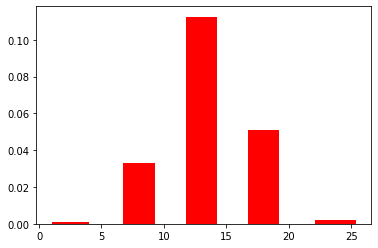

In [55]:
x = traffic_buques.resample('1H').ffill().fillna(0).ships

plt.hist(x=x,bins=[-0.5, 5.5, 10.5, 15.5, 20.5, 27],density=True, rwidth=0.5, color='r')
# plt.grid(True)

(737060.0, 737406.0)

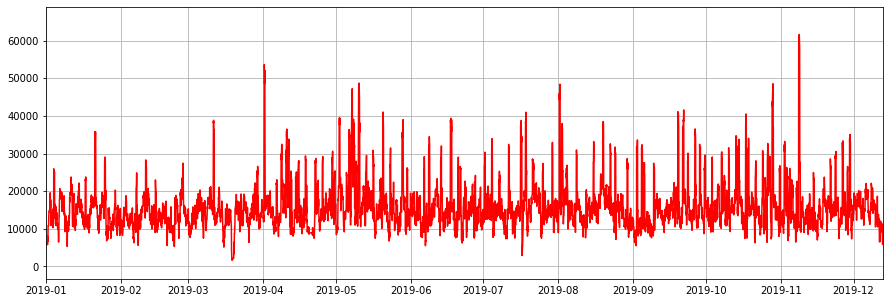

In [56]:
a = figure(figsize=(15,5))

x = traffic_buques.resample('1H').ffill().index
y = traffic_buques.resample('1H').ffill().fillna(0).cum_pot

plt.plot(x,y,'r')
plt.grid(True)
plt.xlim(['2019-12-10','2019-12-13'])
plt.xlim(['2019-01-01','2019-12-13'])

(array([3.400e+01, 4.510e+02, 3.071e+03, 7.370e+03, 7.757e+03, 3.705e+03,
        1.055e+03, 5.610e+02, 6.220e+02, 5.380e+02, 2.870e+02, 1.600e+02,
        8.300e+01, 5.500e+01, 3.400e+01, 1.600e+01, 2.000e+00, 8.000e+00,
        9.000e+00, 3.000e+00]),
 array([    0.        ,  3281.86614073,  6563.73228146,  9845.59842218,
        13127.46456291, 16409.33070364, 19691.19684437, 22973.0629851 ,
        26254.92912583, 29536.79526655, 32818.66140728, 36100.52754801,
        39382.39368874, 42664.25982947, 45946.1259702 , 49227.99211092,
        52509.85825165, 55791.72439238, 59073.59053311, 62355.45667384,
        65637.32281457]),
 <a list of 20 Patch objects>)

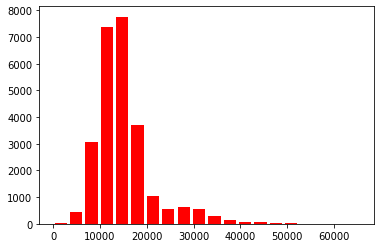

In [58]:
x = traffic_buques.resample('1H').ffill().fillna(0).cum_pot

plt.hist(x=x,bins=20, rwidth= 0.8, color='r')
# plt.grid(True)

## Estudio de potencias

### Corrección de valores de potencia

In [8]:
path = r'C:\Users\badria\OneDrive - FUNDACIÓN VALENCIAPORT\Plan 0 emisiones 2030\vessl'
os.chdir(path)

In [9]:
vessl_mark = pd.read_excel("BERNAT (buques+motores).xlsx", sheet_name='Hoja1')
vessl_jorge = pd.read_excel("total power buques vessl - Jorge.xlsx")

In [10]:
# drop NaN and drop duplicates

vessl_jorge = vessl_jorge.dropna(subset=['IMO','TotalPower']).drop_duplicates(subset='IMO')

vessl_mark = vessl_mark.sort_values(by='Main/Auxiliary',
                       ascending=False).dropna(subset=['IMO',
                                                       'TotalPower']).drop_duplicates(subset=['IMO',
                                                                                              'TotalPower'])

In [44]:
vessl_mark.columns

Index(['VesselTypeName', 'IMO', 'VesselName', 'Operator', 'NumberEngines',
       'Main/Auxiliary', 'EngineName', 'PowerPerEngine', 'DWT', 'GT', 'TEU',
       'ReeferTEU', 'TotalPower'],
      dtype='object')

In [46]:
vessl_jorge.columns

Index(['IMO', 'VesselName', 'VesselTypeName', 'TotalPower', 'ServiceSpeed',
       'GT'],
      dtype='object')

In [11]:
# IMO integer
vessl_jorge.IMO = vessl_jorge.IMO.astype('int')
buques['Clave Lloyd o Num. OMI'] = buques['Clave Lloyd o Num. OMI'].astype('int')

In [65]:
vessl_inner = pd.merge(vessl_jorge,vessl_mark[['IMO','TotalPower']],on = 'IMO',how='inner')
vessl_inner['same?'] = np.where(vessl_inner['TotalPower_x']==vessl_inner['TotalPower_y'],'yes','no') 
vessl_inner['same?'].describe()

del vessl_inner

In [12]:
buques_vessl = pd.merge(buques, vessl_jorge[['IMO','TotalPower','GT']],left_on='Clave Lloyd o Num. OMI',
                                                        right_on ='IMO',how='left')

In [92]:
buques_vessl.columns

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Tipo Buque', 'Det. G.T. Buque', 'Num. Atraque', 'Power (kW)',
       'Potencia', 'Muelle Atraque Real', 'Tipo Maniobra',
       'Fecha de Fin del Servicio', 'Hora de Fin del Servicio',
       'Fecha de Inicio de Servicio', 'Hora de Inicio del Servicio',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'GT*t', 'Potencia*atraque', 'GT*atraque', 'Paux_a(kW)', 'Paux_b(kW)',
       'Paux_a*t (kWh)', 'Paux_b*t (kWh)', 'Unnamed: 25', 'Potencia_kW',
       'terminal', 'buque_def', 'IMO', 'TotalPower', 'GT'],
      dtype='object')

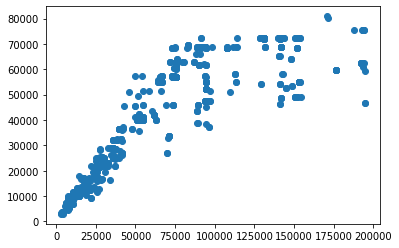

In [15]:
plt.scatter(buques_vessl.drop_duplicates(subset='IMO').GT[buques_vessl.buque_def=='contenedor'],
            buques_vessl.drop_duplicates(subset='IMO').TotalPower[buques_vessl.buque_def=='contenedor'])

In [46]:
ihs_db.columns

Index(['IMO/LR/IHS No.', 'Name of Ship', 'Ship Type', 'GT', 'Service Speed',
       'Total KW Main Eng', 'Aux. Engine Model', 'Aux. Engine Total KW',
       'Year', 'Reefer Points', 'TEU'],
      dtype='object')

In [16]:
buques_vessl.describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,IMO,TotalPower,GT
count,19845.000000,1.984500e+04,19845.000000,19845.000000,0.0,19845.000000,19845.000000,19845.000000,19845.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.755700e+04,17557.000000,17557.000000
mean,2017.978987,9.290158e+06,38628.324969,1.226405,NaN,32153.284958,1282.882439,1264.011791,17.560833,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.289105e+06,26462.961383,37873.502819
std,0.815907,3.241433e+05,34619.718435,0.540804,NaN,25175.980617,660.081046,660.296239,18.577895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.148754e+05,18048.207290,33438.591475
min,2017.000000,5.142657e+06,682.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.166667,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,7.360617e+06,1980.000000,2906.000000
25%,2017.000000,9.214202e+06,16686.000000,1.000000,NaN,13229.000000,740.000000,725.000000,8.083333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.220328e+06,11620.000000,16686.000000
50%,2018.000000,9.323637e+06,26375.000000,1.000000,NaN,25696.000000,1325.000000,1310.000000,14.500000,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.320441e+06,21600.000000,26375.000000
75%,2019.000000,9.458523e+06,51714.000000,1.000000,NaN,42500.000000,1910.000000,1855.000000,22.416667,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.458523e+06,36540.000000,49810.000000
max,2019.000000,9.842097e+06,228081.000000,8.000000,NaN,119916.000000,2359.000000,2355.000000,438.333333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.842085e+06,80905.000000,194849.000000


In [13]:
pd.merge(buques[buques.buque_def=='contenedor'], vessl_jorge[['IMO','TotalPower','GT']],left_on='Clave Lloyd o Num. OMI',
                                                        right_on ='IMO',how='left').describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,IMO,TotalPower,GT
count,11780.000000,1.178000e+04,11780.000000,11780.000000,0.0,11780.000000,11780.000000,11780.000000,11780.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.076500e+04,10765.000000,10765.000000
mean,2017.971307,9.321783e+06,44478.402207,1.351783,NaN,36363.793379,1156.725722,1140.005942,20.188473,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.321506e+06,30086.977613,44594.818393
std,0.814708,1.893715e+05,40600.606931,0.642881,NaN,29512.246508,682.097658,683.223289,11.939128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.883750e+05,21990.566616,40518.925332
min,2017.000000,7.810222e+06,998.000000,1.000000,NaN,54.000000,0.000000,0.000000,1.583333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,8.201648e+06,2942.000000,2906.000000
25%,2017.000000,9.210074e+06,9957.000000,1.000000,NaN,11957.000000,625.000000,610.000000,12.833333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.210098e+06,9730.000000,9957.000000
50%,2018.000000,9.316347e+06,27915.000000,1.000000,NaN,28880.000000,1210.000000,1200.000000,18.041667,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.316347e+06,25040.000000,28592.000000
75%,2019.000000,9.403440e+06,72884.000000,2.000000,NaN,57677.000000,1755.000000,1745.000000,24.500000,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.403437e+06,47430.000000,72884.000000
max,2019.000000,9.842097e+06,194849.000000,6.000000,NaN,114239.000000,2359.000000,2355.000000,236.833333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.842085e+06,80905.000000,194849.000000


In [20]:
pd.merge(buques[buques.buque_def=='contenedor'], ihs_db[['IMO/LR/IHS No.','Total KW Main Eng','GT']],left_on='Clave Lloyd o Num. OMI',
                                                        right_on ='IMO/LR/IHS No.',how='left').describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,IMO/LR/IHS No.,Total KW Main Eng,GT
count,11780.000000,1.178000e+04,11780.000000,11780.000000,0.0,11780.000000,11780.000000,11780.000000,11780.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.096500e+04,10965.000000,10965.000000
mean,2017.971307,9.321783e+06,44478.402207,1.351783,NaN,36363.793379,1156.725722,1140.005942,20.188473,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.334624e+06,31673.273415,47217.503238
std,0.814708,1.893715e+05,40600.606931,0.642881,NaN,29512.246508,682.097658,683.223289,11.939128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.768292e+05,21922.064659,40730.195549
min,2017.000000,7.810222e+06,998.000000,1.000000,NaN,54.000000,0.000000,0.000000,1.583333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,8.201648e+06,2999.000000,2906.000000
25%,2017.000000,9.210074e+06,9957.000000,1.000000,NaN,11957.000000,625.000000,610.000000,12.833333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.226504e+06,9730.000000,9962.000000
50%,2018.000000,9.316347e+06,27915.000000,1.000000,NaN,28880.000000,1210.000000,1200.000000,18.041667,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.320441e+06,28348.000000,35708.000000
75%,2019.000000,9.403440e+06,72884.000000,2.000000,NaN,57677.000000,1755.000000,1745.000000,24.500000,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.406635e+06,51014.000000,74656.000000
max,2019.000000,9.842097e+06,194849.000000,6.000000,NaN,114239.000000,2359.000000,2355.000000,236.833333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.842097e+06,80905.000000,194849.000000


In [14]:
vessl_ihs = pd.merge(vessl_jorge,
                     ihs_db[['IMO/LR/IHS No.', 'Name of Ship', 'Ship Type', 'GT', 'Service Speed','Total KW Main Eng']],
                     left_on='IMO',right_on ='IMO/LR/IHS No.',how='outer')

In [15]:
# en caso de IMO igual y power diferente, me quedo con datos ihs

condition = (vessl_ihs.IMO == vessl_ihs['IMO/LR/IHS No.'])
vessl_ihs.TotalPower[condition] = vessl_ihs['Total KW Main Eng'][condition]
vessl_ihs[condition][vessl_ihs.TotalPower[condition].isin(vessl_ihs['Total KW Main Eng'][condition]) == False]    

,IMO,VesselName,VesselTypeName,TotalPower,ServiceSpeed,GT_x,IMO/LR/IHS No.,Name of Ship,Ship Type,GT_y,Service Speed,Total KW Main Eng


In [49]:
# check correcto
vessl_ihs[vessl_ihs.VesselName=='MSC TINA']

,IMO,VesselName,VesselTypeName,TotalPower,ServiceSpeed,GT_x,IMO/LR/IHS No.,Name of Ship,Ship Type,GT_y,Service Speed,Total KW Main Eng
561,9762340.0,MSC TINA,CONTAINERSHIP,62380.0,19.0,193000.0,9762340.0,MSC TINA,Container Ship (Fully Cellular),194308.0,19.0,62380.0


In [16]:
vessl_ihs

,IMO,VesselName,VesselTypeName,TotalPower,ServiceSpeed,GT_x,IMO/LR/IHS No.,Name of Ship,Ship Type,GT_y,Service Speed,Total KW Main Eng
0,8820016.0,CLARA MAERSK,CONTAINERSHIP,10480.0,18.25,18979.0,NaN,NaN,NaN,NaN,NaN,NaN
1,8913423.0,MSC SHANNON,CONTAINERSHIP,21700.0,21.00,37071.0,8913423.0,MSC SHANNON,Container Ship (Fully Cellular),37071.0,21.0,21700.0
2,8918978.0,MSC SUEZ,CONTAINERSHIP,21700.0,21.00,37071.0,8918978.0,MSC SUEZ,Container Ship (Fully Cellular),37071.0,21.0,21700.0
3,9064267.0,THOMAS MAERSK,CONTAINERSHIP,11418.0,18.50,18859.0,NaN,NaN,NaN,NaN,NaN,NaN
4,9064279.0,TINGLEV MAERSK,CONTAINERSHIP,11414.0,18.60,18859.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6727,NaN,NaN,NaN,NaN,NaN,NaN,9839466.0,MSC MIA,Container Ship (Fully Cellular),232618.0,18.5,75570.0
6728,NaN,NaN,NaN,NaN,NaN,NaN,9839260.0,MSC MINA,Container Ship (Fully Cellular),228741.0,18.5,75570.0
6729,NaN,NaN,NaN,NaN,NaN,NaN,9839296.0,MSC NELA,Container Ship (Fully Cellular),228741.0,18.5,75570.0
6730,NaN,NaN,NaN,NaN,NaN,NaN,9839442.0,MSC SAMAR,Container Ship (Fully Cellular),232618.0,18.5,75570.0


In [17]:
# fill gaps

condition =(vessl_ihs['Total KW Main Eng'].isnull() == True)
vessl_ihs['Total KW Main Eng'][condition] = vessl_ihs.TotalPower[condition]

condition =(vessl_ihs.IMO.isnull() == True)
vessl_ihs.IMO[condition] = vessl_ihs['IMO/LR/IHS No.'][condition]

condition =(vessl_ihs.VesselName.isnull() == True)
vessl_ihs.VesselName[condition] = vessl_ihs['Name of Ship'][condition]

condition =(vessl_ihs.VesselTypeName.isnull() == True)
vessl_ihs.VesselTypeName[condition] = vessl_ihs['Ship Type'][condition]

condition =(vessl_ihs.ServiceSpeed.isnull() == True)
vessl_ihs.ServiceSpeed[condition] = vessl_ihs['Service Speed'][condition]

condition =(vessl_ihs.GT_y.isnull() == True)
vessl_ihs.GT_y[condition] = vessl_ihs.GT_x[condition]

In [56]:
vessl_ihs.describe(include='all')

,IMO,VesselName,VesselTypeName,TotalPower,ServiceSpeed,GT_x,IMO/LR/IHS No.,Name of Ship,Ship Type,GT_y,Service Speed,Total KW Main Eng
count,6.732000e+03,6732,6732,6731.000000,6729.000000,6731.000000,5.272000e+03,5272,5272,6731.000000,5272.000000,6731.000000
unique,NaN,6702,24,NaN,NaN,NaN,NaN,5259,3,NaN,NaN,NaN
top,NaN,FREJ,Container Ship (Fully Cellular),NaN,NaN,NaN,NaN,HAI SHENG,Container Ship (Fully Cellular),NaN,NaN,NaN
freq,NaN,2,3794,NaN,NaN,NaN,NaN,2,5260,NaN,NaN,NaN
mean,9.316944e+06,NaN,NaN,25277.994800,20.353030,41367.531867,9.388164e+06,NaN,NaN,41367.531867,20.442561,25277.994800
std,4.074564e+05,NaN,NaN,20916.611062,4.708219,43515.677395,2.966533e+05,NaN,NaN,43515.677395,4.122304,20916.611062
min,5.202201e+06,NaN,NaN,150.000000,0.000000,90.000000,5.202201e+06,NaN,NaN,90.000000,0.000000,150.000000
25%,9.214975e+06,NaN,NaN,8530.500000,18.000000,9962.000000,9.251154e+06,NaN,NaN,9962.000000,18.500000,8530.500000
50%,9.337670e+06,NaN,NaN,16980.000000,20.500000,26375.000000,9.356230e+06,NaN,NaN,26375.000000,21.000000,16980.000000
75%,9.502877e+06,NaN,NaN,40040.000000,23.300000,54940.000000,9.550386e+06,NaN,NaN,54940.000000,23.500000,40040.000000


In [18]:
vessl_ihs.TotalPower = vessl_ihs['Total KW Main Eng']
vessl_ihs.GT_x = vessl_ihs.GT_y

In [19]:
vessl_ihs = vessl_ihs[['IMO','VesselName','VesselTypeName','TotalPower','ServiceSpeed','GT_x']]

In [20]:
vessl_ihs=vessl_ihs.rename(columns = {'GT_x':'GT'})

In [65]:
buques.columns

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Tipo Buque', 'Det. G.T. Buque', 'Num. Atraque', 'Power (kW)',
       'Potencia', 'Muelle Atraque Real', 'Tipo Maniobra',
       'Fecha de Fin del Servicio', 'Hora de Fin del Servicio',
       'Fecha de Inicio de Servicio', 'Hora de Inicio del Servicio',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'GT*t', 'Potencia*atraque', 'GT*atraque', 'Paux_a(kW)', 'Paux_b(kW)',
       'Paux_a*t (kWh)', 'Paux_b*t (kWh)', 'Unnamed: 25', 'Potencia_kW',
       'terminal', 'buque_def'],
      dtype='object')

In [21]:
buques_vessl_ihs = pd.merge(buques, vessl_ihs[['IMO','TotalPower','GT']],left_on='Clave Lloyd o Num. OMI',
                                                        right_on ='IMO',how='left')

In [93]:
# datos de escalas BO vs vessl_ihs

for each in buques_vessl_ihs.buque_def.unique():
    condition = (buques_vessl_ihs.buque_def==each)
    a = len(buques_vessl_ihs[condition])
    b = buques_vessl_ihs[condition].TotalPower.count()
    print(str(each)+'   '+str(a)+'   '+str(b))

contenedor   11780   11500
roro   2610   2423
otros   482   2
ropax   4375   4308
crucero   598   150


2020-10-08 12:04:08,774 [15380] WARNING  py.warnings:110: [JupyterRequire] C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.


2020-10-08 12:04:08,786 [15380] WARNING  py.warnings:110: [JupyterRequire] C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.




contenedor   1101   934
roro   134   88
otros   252   5
ropax   28   26
crucero   129   40


Text(0, 0.5, 'Potencia')

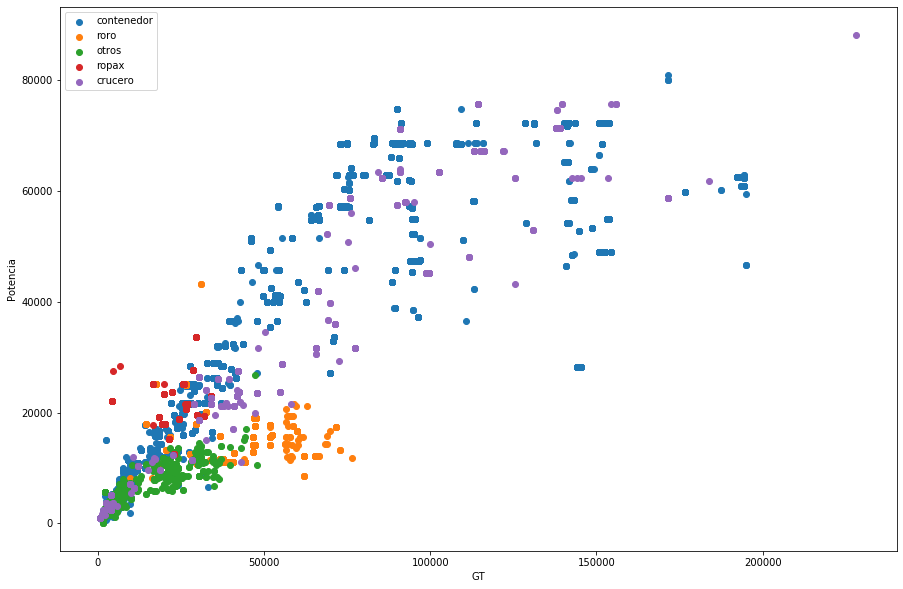

In [12]:
fig = plt.figure(figsize=(15,10))

names=[]
for each in buques.buque_def.unique():
    
    condition = (buques.buque_def==each)
    a = len(buques.drop_duplicates(subset='Clave Lloyd o Num. OMI')[condition])
    b = buques.drop_duplicates(subset='Clave Lloyd o Num. OMI')[condition].TotalPower.count()
    print(str(each)+'   '+str(a)+'   '+str(b))
    
    plt.scatter(buques['Det. G.T. Buque'][condition],buques.Potencia[condition])
    plt.legend(['contenedor','roro','otros','ropax','crucero'])
plt.xlabel('GT')    
plt.ylabel('Potencia')

In [16]:
buques[buques.buque_def=='crucero']

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,Potencia_kW,terminal,buque_def,IMO,TotalPower,GT,Manoeuvring
299,2017,1 2017 242,9237345,COSTA MEDITERRANEA,CRUCERO TURÍSTICO,85619.0,1,NaN,84798.0,PONIENTE-1,...,NaN,NaN,NaN,18231.6,trasme_cru,crucero,NaN,NaN,NaN,18994.8
389,2017,1 2017 338,9141065,NORWEGIAN SPIRIT,CRUCERO TURÍSTICO,75904.0,1,NaN,79944.0,PONIENTE-2,...,NaN,NaN,NaN,17188,trasme_cru,crucero,NaN,NaN,NaN,17907.5
505,2017,1 2017 460,9237345,COSTA MEDITERRANEA,CRUCERO TURÍSTICO,85619.0,1,NaN,84798.0,CRUCEROS DOS,...,NaN,NaN,NaN,18231.6,ampli_norte,crucero,NaN,NaN,NaN,18994.8
666,2017,1 2017 625,9725421,VIKING SEA,CRUCERO TURÍSTICO,47842.0,1,NaN,23520.0,PONIENTE-1,...,NaN,NaN,NaN,4186.56,trasme_cru,crucero,NaN,23520.0,NaN,5268.48
743,2017,1 2017 700,9141065,NORWEGIAN SPIRIT,CRUCERO TURÍSTICO,75904.0,1,NaN,79944.0,PONIENTE-1,...,NaN,NaN,NaN,17188,trasme_cru,crucero,NaN,NaN,NaN,17907.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19628,2019,1 2019 6083,9228356,JEWEL OF THE SEAS,CRUCERO TURÍSTICO,90090.0,1,NaN,78177.0,CRUCEROS UNO,...,NaN,NaN,NaN,16808.1,ampli_norte,crucero,NaN,NaN,NaN,17511.6
19659,2019,1 2019 6115,8700280,AMERA,CRUCERO TURÍSTICO,39051.0,1,NaN,28720.0,PONIENTE-2,...,NaN,NaN,NaN,5112.16,trasme_cru,crucero,NaN,NaN,NaN,6433.28
19709,2019,1 2019 6175,9239795,COSTA MAGICA,CRUCERO TURÍSTICO,102587.0,1,NaN,86146.0,PONIENTE-2,...,NaN,NaN,NaN,13008,trasme_cru,crucero,NaN,NaN,NaN,19296.7
19724,2019,1 2019 6192,9678408,MEIN SCHIFF 4,CRUCERO TURÍSTICO,99526.0,1,NaN,45200.0,PONIENTE-2,...,NaN,NaN,NaN,9718,trasme_cru,crucero,9678408.0,45200.0,99526.0,10124.8


2020-09-28 18:30:50,107 [18508] WARNING  py.warnings:110: [JupyterRequire] C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.


2020-09-28 18:30:50,117 [18508] WARNING  py.warnings:110: [JupyterRequire] C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.




contenedor   1101   934
roro   134   88
otros   252   2
ropax   28   26
crucero   129   39


<Figure size 1080x1080 with 0 Axes>

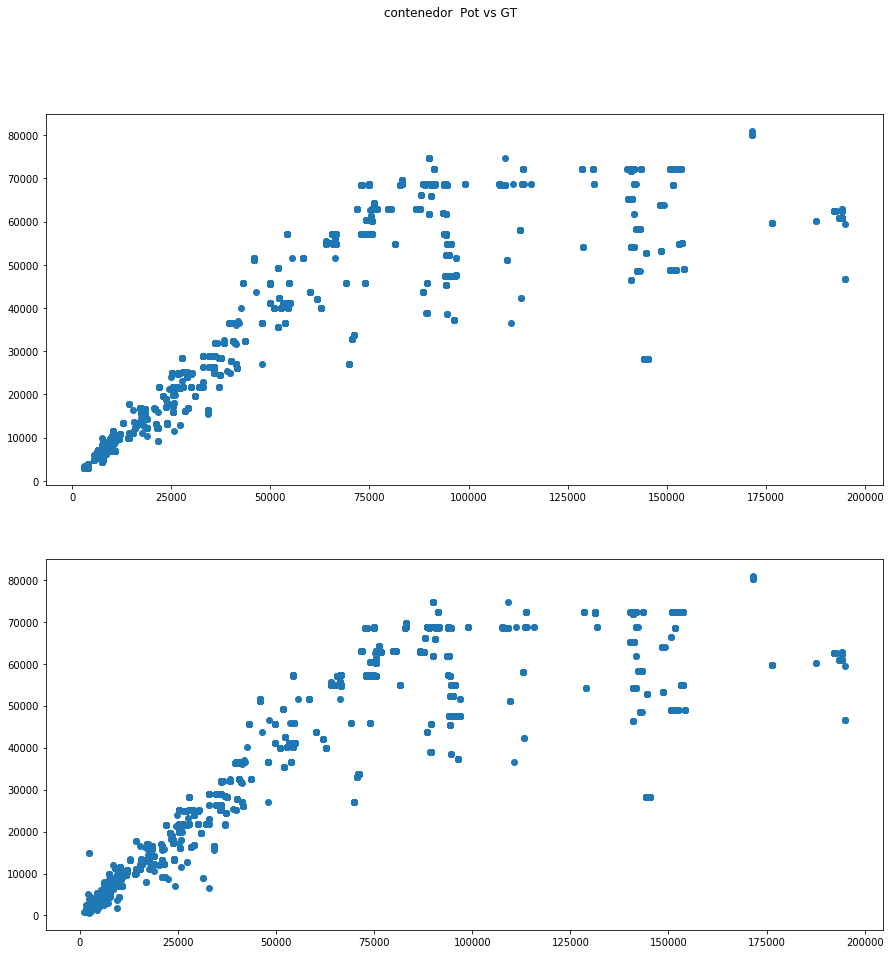

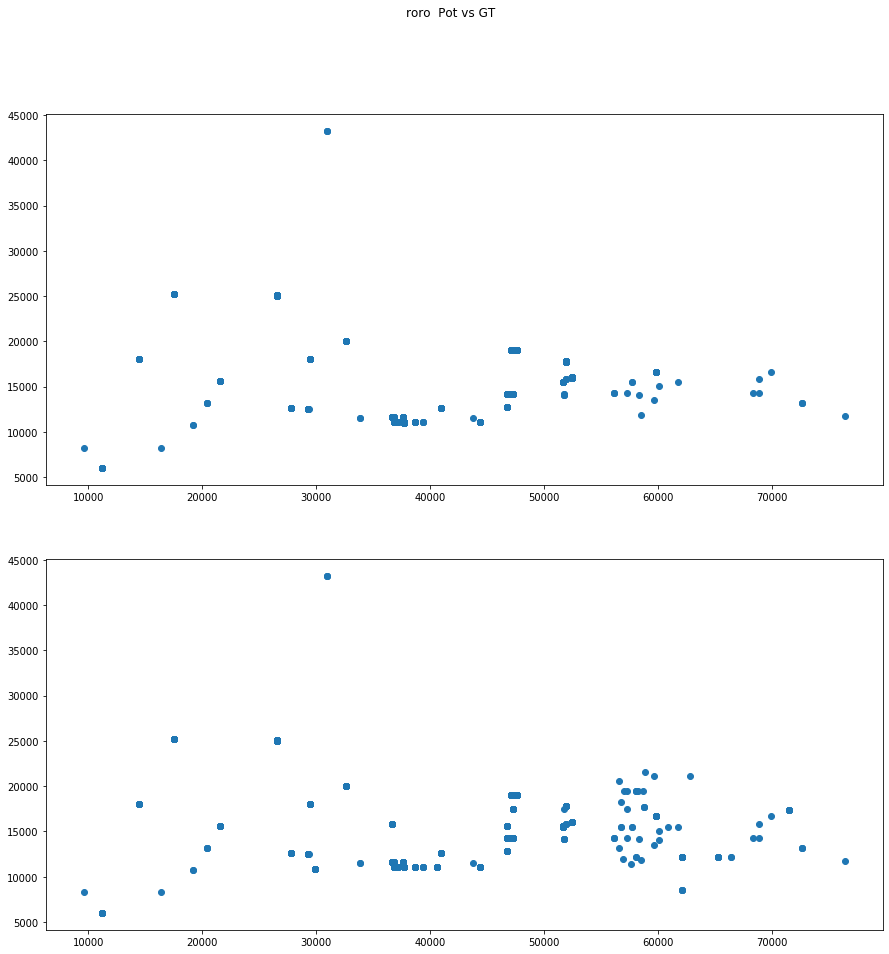

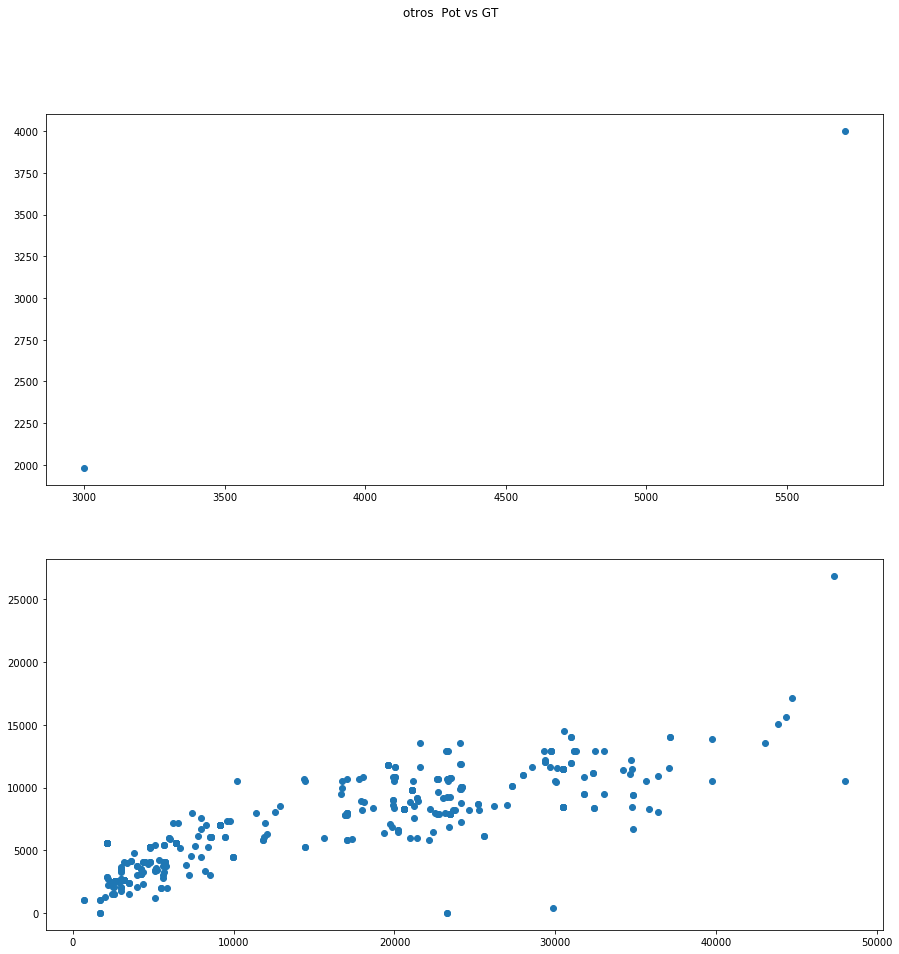

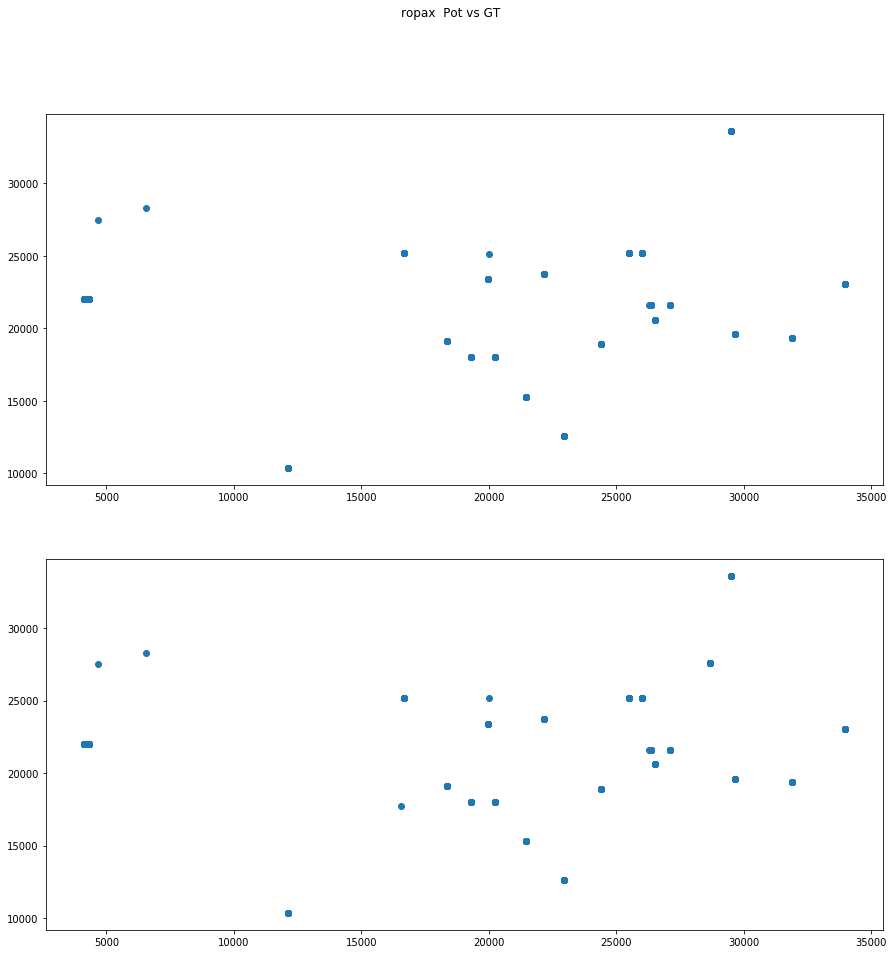

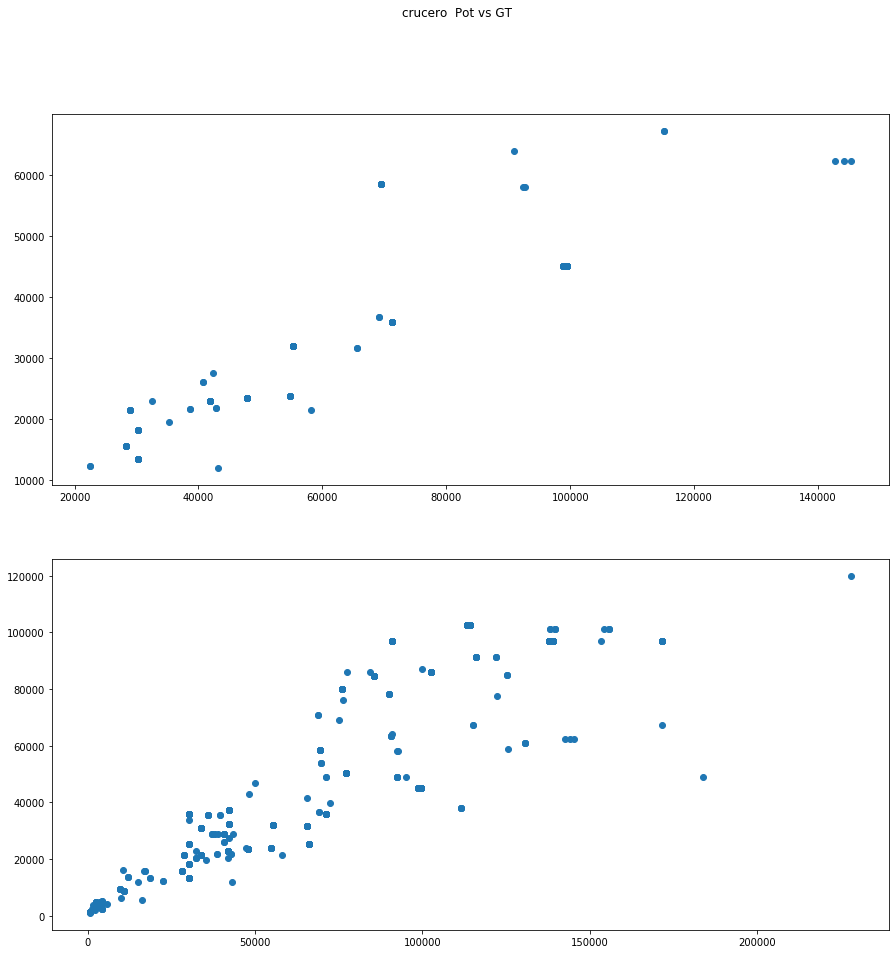

In [137]:
# datos de buques BO vs vessl_ihs
fig = plt.figure(figsize=(15,15))
for each in buques_vessl_ihs.buque_def.unique():
    condition = (buques_vessl_ihs.buque_def==each)
    a = len(buques_vessl_ihs.drop_duplicates(subset='Clave Lloyd o Num. OMI')[condition])
    b = buques_vessl_ihs.drop_duplicates(subset='Clave Lloyd o Num. OMI')[condition].TotalPower.count()
    print(str(each)+'   '+str(a)+'   '+str(b))
    
    fig, axs = plt.subplots(2,figsize=(15,15))
    fig.suptitle(str(each) + '  Pot vs GT')
    axs[0].scatter(buques_vessl_ihs['Det. G.T. Buque'][condition], buques_vessl_ihs.TotalPower[condition])
    axs[1].scatter(buques_vessl_ihs['Det. G.T. Buque'][condition], buques_vessl_ihs.Potencia[condition])

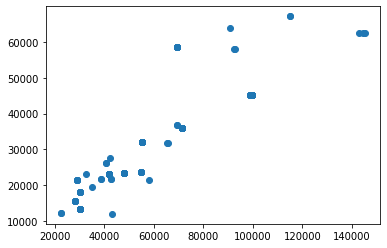

In [104]:
condition = (buques_vessl_ihs.buque_def=='crucero')
plt.scatter(buques_vessl_ihs['Det. G.T. Buque'][condition],buques_vessl_ihs.TotalPower[condition])

In [115]:
buques_vessl_ihs[condition].TotalPower.describe()

count      150.000000
mean     31536.293333
std      13331.983656
min      12000.000000
25%      23040.000000
50%      31680.000000
75%      36000.000000
max      67200.000000
Name: TotalPower, dtype: float64

In [161]:
condition = (buques_vessl_ihs.buque_def=='crucero')
#buques_vessl_ihs[condition & (buques_vessl_ihs.Potencia>500) & (buques_vessl_ihs.Potencia<10000) &
#                             (buques_vessl_ihs['Det. G.T. Buque']>20000)].drop_duplicates(subset='Clave Lloyd o Num. OMI')

buques_vessl_ihs[condition & (buques_vessl_ihs.Potencia>20000) &
                             (buques_vessl_ihs['Det. G.T. Buque']>200000)].drop_duplicates(subset='Clave Lloyd o Num. OMI')


,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,Potencia_kW,terminal,buque_def,IMO,TotalPower,GT
12285,2018,1 2018 5456,9744001,SYMPHONY OF THE SEAS,CRUCERO TURÍSTICO,228081.0,1,NaN,119916.0,CRUCEROS UNO,...,NaN,NaN,NaN,NaN,18107.3,ampli_norte,crucero,NaN,NaN,NaN


In [150]:
# EPA EMEP
# Trozzi 2010, https://www3.epa.gov/ttnchie1/conference/ei19/session10/trozzi.pdf
# 14.755*(GT^0.6082)

14.755*(23236**0.6082)

6674.804617884086

petroleros (otros)

scf pechora https://www.balticshipping.com/vessel/imo/9333424 13560
searambler 6675 kW
seapromise 6675 kW

In [156]:
buques_vessl_ihs.Potencia[buques_vessl_ihs['Clave Lloyd o Num. OMI']==9333424] = 13560
buques_vessl_ihs.TotalPower[buques_vessl_ihs['Clave Lloyd o Num. OMI']==9333424] = 13560

buques_vessl_ihs.Potencia[buques_vessl_ihs['Clave Lloyd o Num. OMI'].isin([9236743,9247479])==True] = 6675
buques_vessl_ihs.TotalPower[buques_vessl_ihs['Clave Lloyd o Num. OMI'].isin([9236743,9247479])==True] = 6675

cruceros

< 501 kW

MSC poesia https://en.wikipedia.org/wiki/MSC_Poesia 58000 kW
Thomson Dream https://en.wikipedia.org/wiki/MS_Marella_Dream 23800 kW
Mein Schiff 3 https://de.wikipedia.org/wiki/Mein_Schiff_3 48000 kW
Azamara Journey https://www.scheepvaartwest.be/CMS/index.php/passengers-cruise/2640-azamara-journey-imo-9200940
                https://www.wartsila.com/marine/build/engines-and-generating-sets/diesel-engines/wartsila-32 18200 kW
World odissey http://www.nedcruise.info/world%20odyssey.htm 12320
Tui discovery 2 https://en.wikipedia.org/wiki/Marella_Discovery_2 58500 kW
Ocean Dream https://en.wikipedia.org/wiki/Ocean_Dream_(1982_ship) 19570 kW
Viking Star https://en.wikipedia.org/wiki/MV_Viking_Star 23520 kW
Viking sea https://en.wikipedia.org/wiki/MV_Viking_Sea_(2015) 23520 kW
            
501 < kW < 10000

Viking sky https://en.wikipedia.org/wiki/MV_Viking_Sky  23520 kW
Azura  https://www.fincantieri.com/en/products-and-services/cruise-ships/azura/ 67200 kW
Seabourn encore  https://en.wikipedia.org/wiki/MV_Seabourn_Encore  23040 kW
Queen Elisabeth https://en.wikipedia.org/wiki/MS_Queen_Elizabeth 64000 kW
Silver Shadow  http://www.nedcruise.info/silver%20shadow.htm  15700 kW

10000 < kW < 20000

MSC Musica https://es.wikipedia.org/wiki/MSC_Musica  58000 kW
Majestic Princess https://en.wikipedia.org/wiki/Majestic_Princess 62400 kW
Seven Seas Explorer https://www.fincantieri.com/en/products-and-services/cruise-ships/seven-seas-explorer/ 32000 kW
Sirena https://en.wikipedia.org/wiki/MS_Sirena i https://www.ship-technology.com/projects/sirena-cruise-ship/  13500 kW
Silver Muse https://en.wikipedia.org/wiki/Silver_Muse 26100 (diesel) o 17000 (electric). Vessel diu 17000 kW
            https://www.fincantieri.com/en/products-and-services/cruise-ships/silver-muse/ 26100 kW
            http://www.nedcruise.info/silver%20muse.htm 26100 kW
Royal Princess https://en.wikipedia.org/wiki/Royal_Princess_(2012) 62400 kW
Viking Sun  https://en.wikipedia.org/wiki/MV_Viking_Sun 23520 kW
MSC Armonia https://en.wikipedia.org/wiki/MSC_Armonia 31680 kW
The World   https://es.wikipedia.org/wiki/The_World_(barco) 12000 kW
Seabourn quest https://en.wikipedia.org/wiki/MV_Seabourn_Quest  23040 kW
MSC OPera  https://es.wikipedia.org/wiki/MSC_Opera 31680 kW
Silver whisper http://www.nedcruise.info/silver_whisper.htm 15700 kW, és correcte
Viking Jupter https://www.fincantieri.com/en/products-and-services/cruise-ships/viking-jupiter/ 23520 kW
Spirit of discovery https://en.wikipedia.org/wiki/Spirit_of_Discovery_(2019) 21600 kW
Sky princess https://en.wikipedia.org/wiki/Sky_Princess_(2019) 62400 kW

In [17]:
203+203+193

599

In [79]:
buques_vessl_ihs[condition & (buques_vessl_ihs.Potencia<20001) &
                             (buques_vessl_ihs['Det. G.T. Buque']>20000)].drop_duplicates(subset='Clave Lloyd o Num. OMI')

SyntaxError: invalid syntax (<ipython-input-79-eb45494aca1e>, line 1)

In [169]:
buques_vessl_ihs.TotalPower[buques_vessl_ihs['Clave Lloyd o Num. OMI']==9744001] = 96800 #kW, 
# https://en.wikipedia.org/wiki/Symphony_of_the_Seas

In [173]:
buques_vessl_ihs[buques_vessl_ihs['Clave Lloyd o Num. OMI']==9744001]

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,Potencia_kW,terminal,buque_def,IMO,TotalPower,GT
12285,2018,1 2018 5456,9744001,SYMPHONY OF THE SEAS,CRUCERO TURÍSTICO,228081.0,1,NaN,96800.0,CRUCEROS UNO,...,NaN,NaN,NaN,NaN,18107.3,ampli_norte,crucero,NaN,96800.0,NaN


In [172]:
# if TotalPower, GT exist --> then Potencia = TotalPower, Det GT Buque = GT

buques_vessl_ihs['Potencia'] = np.where(buques_vessl_ihs['TotalPower'].isnull()==False,
                                       buques_vessl_ihs['TotalPower'],buques_vessl_ihs['Potencia'])
buques_vessl_ihs['Det. G.T. Buque'] = np.where(buques_vessl_ihs['GT'].isnull()==False,
                                       buques_vessl_ihs['GT'],buques_vessl_ihs['Det. G.T. Buque'])

In [111]:
buques_vessl_ihs[condition].describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,IMO,TotalPower,GT
count,598.000000,5.980000e+02,598.000000,598.000000,0.0,598.000000,598.000000,598.000000,598.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.900000e+01,150.000000,59.000000
mean,2017.996656,9.217854e+06,73418.165552,1.010033,NaN,51655.061873,833.871237,798.913043,10.490942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.547421e+06,31536.293333,71611.949153
std,0.822621,5.607620e+05,47294.403175,0.099747,NaN,35376.697185,176.638835,182.629195,5.526879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.761063e+05,13331.983656,21962.100775
min,2017.000000,5.142657e+06,693.000000,1.000000,NaN,1014.000000,0.000000,555.000000,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.112789e+06,12000.000000,28890.000000
25%,2017.000000,9.160304e+06,33930.750000,1.000000,NaN,23520.000000,750.000000,730.000000,8.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.490052e+06,23040.000000,71304.000000
50%,2018.000000,9.320556e+06,71304.000000,1.000000,NaN,37455.000000,805.000000,740.000000,9.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.601132e+06,31680.000000,71304.000000
75%,2019.000000,9.585285e+06,114288.000000,1.000000,NaN,96860.000000,840.000000,820.000000,10.416667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.641730e+06,36000.000000,98785.000000
max,2019.000000,9.814040e+06,228081.000000,2.000000,NaN,119916.000000,2120.000000,2345.000000,62.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.784350e+06,67200.000000,99526.000000


In [92]:
cru_imo = [9725421,9320087,9650420,9650418,9424883,9614141,9703150,
           7915096,9070620,9187899,9731171,9784350,9141807,9200940,
           9584712,9725433,8407735,9210141,9219331,9483126,9477438,
           9387073,9250464,9192179,9192167,9796262,9802683,9802396]

cru_pot = [23520,58000,23520,23520,67200,62400,32000,
           19570,58500,13500,23040,26100,12320,18200,
           62400,23520,23800,31680,12000,23040,64000,
           58000,31680,15700,15700,23520,21600,62400]

for i, j in zip(cru_imo, cru_pot):
    buques_vessl_ihs.TotalPower[buques_vessl_ihs['Clave Lloyd o Num. OMI']==i]=j
    print(buques_vessl_ihs.TotalPower[buques_vessl_ihs['Clave Lloyd o Num. OMI']==i])

666      23520.0
876      23520.0
1095     23520.0
8477     23520.0
15099    23520.0
Name: TotalPower, dtype: float64
935    58000.0
Name: TotalPower, dtype: float64
1098     23520.0
8080     23520.0
13189    23520.0
13529    23520.0
19788    23520.0
Name: TotalPower, dtype: float64
1283    23520.0
6347    23520.0
6760    23520.0
7039    23520.0
7283    23520.0
7528    23520.0
7761    23520.0
8025    23520.0
Name: TotalPower, dtype: float64
1803     67200.0
15254    67200.0
Name: TotalPower, dtype: float64
1871    62400.0
Name: TotalPower, dtype: float64
2297     32000.0
2537     32000.0
2538     32000.0
2698     32000.0
5825     32000.0
5826     32000.0
8344     32000.0
8347     32000.0
9210     32000.0
9211     32000.0
11820    32000.0
16150    32000.0
Name: TotalPower, dtype: float64
2510    19570.0
Name: TotalPower, dtype: float64
2643     58500.0
3029     58500.0
3603     58500.0
3680     58500.0
4192     58500.0
4723     58500.0
19364    58500.0
Name: TotalPower, dtype: float64
3

In [167]:
buques_vessl_ihs.describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,IMO,TotalPower,GT
count,19845.000000,1.984500e+04,19845.000000,19845.000000,0.0,19845.000000,19845.000000,19845.000000,19845.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.829200e+04,18386.000000,18292.000000
mean,2017.978987,9.290158e+06,38622.561804,1.226405,NaN,26708.738473,1282.882439,1264.011791,17.560833,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.291466e+06,26888.706081,38649.518915
std,0.815907,3.241433e+05,34654.764685,0.540804,NaN,19627.046018,660.081046,660.296239,18.577895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.108645e+05,18352.176084,33980.415920
min,2017.000000,5.142657e+06,682.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.166667,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,7.360617e+06,1980.000000,2906.000000
25%,2017.000000,9.214202e+06,16686.000000,1.000000,NaN,11060.000000,740.000000,725.000000,8.083333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.220328e+06,12200.000000,16686.000000
50%,2018.000000,9.323637e+06,26375.000000,1.000000,NaN,21600.000000,1325.000000,1310.000000,14.500000,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.320441e+06,21600.000000,26375.000000
75%,2019.000000,9.458523e+06,51714.000000,1.000000,NaN,36560.000000,1910.000000,1855.000000,22.416667,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.458523e+06,36560.000000,51714.000000
max,2019.000000,9.842097e+06,228081.000000,8.000000,NaN,119916.000000,2359.000000,2355.000000,438.333333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.842097e+06,80905.000000,194849.000000


## Merge contenedores de ihs db (OUTDATED)

In [63]:
ihs_db.columns

Index(['IMO/LR/IHS No.', 'Name of Ship', 'Ship Type', 'GT', 'Service Speed',
       'Total KW Main Eng', 'Aux. Engine Model', 'Aux. Engine Total KW',
       'Year', 'Reefer Points', 'TEU'],
      dtype='object')

In [64]:
pd.merge(buques, ihs_db[['IMO/LR/IHS No.','Total KW Main Eng','GT']],left_on='Clave Lloyd o Num. OMI',
                                                        right_on ='IMO/LR/IHS No.',how='left').describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),GT*t,...,Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,IMO,TotalPower,GT_x,IMO/LR/IHS No.,Total KW Main Eng,GT_y
count,19845.000000,1.984500e+04,19845.000000,19845.000000,0.0,19845.000000,19845.000000,19845.000000,19845.000000,1.0,...,0.0,1.0,0.0,0.0,1.984500e+04,19845.000000,19845.000000,1.096500e+04,10965.000000,10965.000000
mean,2017.978987,9.290158e+06,38628.324969,1.226405,NaN,32153.284958,1282.882439,1264.011791,17.560833,5015400.0,...,NaN,447720.0,NaN,NaN,9.290158e+06,26961.045855,38605.064349,9.334624e+06,31673.273415,47217.503238
std,0.815907,3.241433e+05,34619.718435,0.540804,NaN,25175.980617,660.081046,660.296239,18.577895,NaN,...,NaN,NaN,NaN,NaN,3.241433e+05,20201.621671,34624.458565,1.768292e+05,21922.064659,40730.195549
min,2017.000000,5.142657e+06,682.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.166667,5015400.0,...,NaN,447720.0,NaN,NaN,5.142657e+06,1.000000,682.000000,8.201648e+06,2999.000000,2906.000000
25%,2017.000000,9.214202e+06,16686.000000,1.000000,NaN,13229.000000,740.000000,725.000000,8.083333,5015400.0,...,NaN,447720.0,NaN,NaN,9.214202e+06,11059.000000,16686.000000,9.226504e+06,9730.000000,9962.000000
50%,2018.000000,9.323637e+06,26375.000000,1.000000,NaN,25696.000000,1325.000000,1310.000000,14.500000,5015400.0,...,NaN,447720.0,NaN,NaN,9.323637e+06,21600.000000,26375.000000,9.320441e+06,28348.000000,35708.000000
75%,2019.000000,9.458523e+06,51714.000000,1.000000,NaN,42500.000000,1910.000000,1855.000000,22.416667,5015400.0,...,NaN,447720.0,NaN,NaN,9.458523e+06,36560.000000,51714.000000,9.406635e+06,51014.000000,74656.000000
max,2019.000000,9.842097e+06,228081.000000,8.000000,NaN,119916.000000,2359.000000,2355.000000,438.333333,5015400.0,...,NaN,447720.0,NaN,NaN,9.842097e+06,119916.000000,228081.000000,9.842097e+06,80905.000000,194849.000000


In [1]:
buques_vessl_ihs.describe()

NameError: name 'buques_vessl_ihs' is not defined

In [2]:
%store -r buques_vessl_ihs

In [3]:
buques_vessl_ihs[buques_vessl_ihs['Clave Lloyd o Num. OMI']==9744001]

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,Potencia_kW,terminal,buque_def,IMO,TotalPower,GT
12285,2018,1 2018 5456,9744001,SYMPHONY OF THE SEAS,CRUCERO TURÍSTICO,228081.0,1,NaN,96800.0,CRUCEROS UNO,...,NaN,NaN,NaN,NaN,18107.3,ampli_norte,crucero,NaN,96800.0,NaN


## Proves

In [8]:
%store -r buques2

In [10]:
buques = buques2
del buques2

In [11]:
buques.describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW)_x,Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),GT*t,...,Paux_b(kW)_x,Paux_a*t (kWh),Paux_b*t (kWh)_x,Unnamed: 25,IMO,TotalPower,GT,Power (kW)_y,Paux_b(kW)_y,Paux_b*t (kWh)_y
count,19845.000000,1.984500e+04,19845.000000,19845.000000,0.0,19845.000000,19845.000000,19845.000000,19845.000000,1.0,...,0.0,1.0,0.0,0.0,1.829200e+04,18387.000000,18292.000000,597.000000,597.000000,597.000000
mean,2017.978987,9.290158e+06,38622.561804,1.226405,NaN,26387.190476,1282.882439,1264.011791,17.560833,5015400.0,...,NaN,447720.0,NaN,NaN,9.291466e+06,26892.508294,38649.518915,41051.244556,7177.966296,70582.156440
std,0.815907,3.241433e+05,34654.764685,0.540804,NaN,18798.009760,660.081046,660.296239,18.577895,NaN,...,NaN,NaN,NaN,NaN,3.108645e+05,18358.917894,33980.415920,24772.019002,4213.951067,50373.872166
min,2017.000000,5.142657e+06,682.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.166667,5015400.0,...,NaN,447720.0,NaN,NaN,7.360617e+06,1980.000000,2906.000000,1060.000000,145.530000,1320.000000
25%,2017.000000,9.214202e+06,16686.000000,1.000000,NaN,11060.000000,740.000000,725.000000,8.083333,5015400.0,...,NaN,447720.0,NaN,NaN,9.220328e+06,12200.000000,16686.000000,21600.000000,3844.800000,38596.799999
50%,2018.000000,9.323637e+06,26375.000000,1.000000,NaN,21600.000000,1325.000000,1310.000000,14.500000,5015400.0,...,NaN,447720.0,NaN,NaN,9.320441e+06,21600.000000,26375.000000,36000.000000,7740.000000,71876.000004
75%,2019.000000,9.458523e+06,51714.000000,1.000000,NaN,36560.000000,1910.000000,1855.000000,22.416667,5015400.0,...,NaN,447720.0,NaN,NaN,9.458523e+06,36560.000000,51714.000000,67200.000000,10781.400000,93940.666673
max,2019.000000,9.842097e+06,228081.000000,8.000000,NaN,88200.000000,2359.000000,2355.000000,438.333333,5015400.0,...,NaN,447720.0,NaN,NaN,9.842097e+06,96800.000000,194849.000000,88200.000000,15317.030000,530990.373320


In [7]:
del buques_vessl_ihs2

In [45]:
# buques.TotalPower[buques.TotalPower.isnull()==True]=buques.Potencia[buques.TotalPower.isnull()==True]
# buques.GT[buques.GT.isnull() == True] = buques['Det. G.T. Buque'][buques.GT.isnull() == True]
buques.IMO[buques.IMO.isnull() == True] = buques['Clave Lloyd o Num. OMI'][buques.IMO.isnull() == True]

In [15]:
buques_vessl.TotalPower.describe()

count     19845.000000
mean      26961.045855
std       20201.621671
min           1.000000
25%       11059.000000
50%       21600.000000
75%       36560.000000
max      119916.000000
Name: TotalPower, dtype: float64

In [17]:
print(len(buques.Potencia))
print(len(buques_vessl.TotalPower))

19845
19845


In [18]:
buques = buques_vessl
del buques_vessl

In [23]:
buques.GT[buques.GT.isnull() == True] = buques['Det. G.T. Buque'][buques.GT.isnull() == True]

In [51]:
buques.drop_duplicates(subset='IMO').GT[buques.buque_def=='contenedor']

0        128600.0
1         35887.0
2         38364.0
3         73819.0
4         23953.0
           ...   
19796     30024.0
19797     96331.0
19820     90449.0
19827      5629.0
19841     16661.0
Name: GT, Length: 1101, dtype: float64

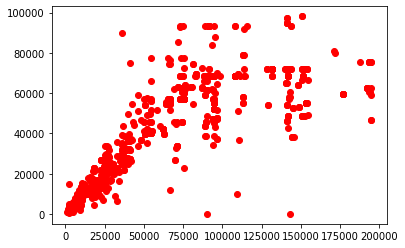

In [59]:
plt.scatter(buques.drop_duplicates(subset='IMO').GT[buques.buque_def=='contenedor'],
            buques.drop_duplicates(subset='IMO').TotalPower[buques.buque_def=='contenedor'],color ='r')
# plt.xlim([0,6000])
# plt.ylim([80000,100000])

In [53]:
buques.drop_duplicates(subset='IMO')[(buques.TotalPower < 20000) & (buques.GT > 50000) & (buques.buque_def == 'contenedor')]

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,Potencia_kW,terminal,buque_def,IMO,TotalPower,GT
8985,2018,1 2018 2131,9293753,CONTI CORTESIA,PORTACONTENEDOR,90449,1,NaN,89,LEVANTE 1,...,NaN,NaN,NaN,NaN,1679.54,apm,contenedor,9293753.0,89.0,90449.0
9385,2018,1 2018 2534,9305570,COSCO GUANGZHOU,PORTACONTENEDOR,109149,1,NaN,10164,PRINCIPE FELIPE,...,NaN,NaN,NaN,NaN,1924.1,csp,contenedor,9305570.0,10164.0,109149.0
16493,2019,1 2019 2964,9189495,SM VANCOUVER,PORTACONTENEDOR,66526,1,NaN,12100,PRINCIPE FELIPE,...,NaN,NaN,NaN,NaN,1844.26,csp,contenedor,9189495.0,12100.0,66526.0
18044,2019,1 2019 4467,9785770,COSCO SHIPPING ORCHI,PORTACONTENEDOR,143179,1,NaN,66,PRINCIPE FELIPE,...,NaN,NaN,NaN,NaN,1680.6,csp,contenedor,9785770.0,66.0,143179.0


cosco guangzhou https://sale-ships.com/cosco-guangzhou/  100.225 hp = 74738 kW
conti cortesia  https://www.balticshipping.com/vessel/imo/9293753 68640 kW
sm vancouver  https://www.balticshipping.com/vessel/imo/9189495 54900 kW
cosco shipping orchid http://uacy.ru/shipsdb/?page&pagename=shipsdb&imo=9785770 48600 kW

In [56]:
buques.drop_duplicates(subset='IMO')[(buques.TotalPower > 60000) & (buques.GT < 50000) & (buques.buque_def == 'contenedor')]

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,Potencia_kW,terminal,buque_def,IMO,TotalPower,GT
7516,2018,1 2018 673,9351579,MSC TAMARA,PORTACONTENEDOR,41225,1,NaN,75000,PRINCIPE FELIPE,...,NaN,NaN,NaN,NaN,1190.09,csp,contenedor,9351579.0,75000.0,41225.0
8480,2018,1 2018 1624,9346017,NORTHERN DECISION,PORTACONTENEDOR,36007,2,NaN,89981,PRINCIPE FELIPE,...,NaN,NaN,NaN,NaN,1190.09,csp,contenedor,9346017.0,89981.0,36007.0


msc tamara http://www.cargo-vessels-international.at/MSC_TAMARA_IMO9351579.pdf   36585 kW
morthern desicion  https://www.balticshipping.com/vessel/imo/9346017   31920 kW

In [57]:
buques.drop_duplicates(subset='IMO')[(buques.TotalPower > 80000) & (buques.buque_def == 'contenedor')]

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,Potencia_kW,terminal,buque_def,IMO,TotalPower,GT
1520,2017,1 2017 1513,9484443,MSC ARIANE,PORTACONTENEDOR,143521,1,NaN,93160,PRINCIPE FELIPE,...,NaN,NaN,NaN,NaN,1924.1,csp,contenedor,9484443.0,93160.0,143521.0
1571,2017,1 2017 1560,9622605,OOCL BERLIN,POLIV. GENERAL CONTENEDOR,141003,1,NaN,94788,LLOVERA,...,NaN,NaN,NaN,NaN,1844.26,apm,contenedor,9622605.0,94788.0,141003.0
1860,2017,1 2017 1857,9321483,EMMA MAERSK,PORTACONTENEDOR,171542,1,NaN,108877,PRINCIPE FELIPE,...,NaN,NaN,NaN,NaN,1924.1,csp,contenedor,9321483.0,80080.0,171542.0
2075,2017,1 2017 2070,9347437,SM HONG KONG,PORTACONTENEDOR,74962,2,NaN,93323,TRANSVERSAL COSTA,...,NaN,NaN,NaN,NaN,1679.54,msc,contenedor,9347437.0,93323.0,74962.0
2383,2017,1 2017 2382,9305477,E.R. TIANSHAN,PORTACONTENEDOR,91649,2,NaN,93323,LLOVERA,...,NaN,NaN,NaN,NaN,1679.54,apm,contenedor,9305477.0,93323.0,91649.0
3062,2017,1 2017 3047,9525871,UNAYZAH,PORTACONTENEDOR,141077,1,NaN,97575,LLOVERA,...,NaN,NaN,NaN,NaN,1924.1,apm,contenedor,9525871.0,97575.0,141077.0
3702,2017,1 2017 3716,9318046,E.R. TOKYO,PORTACONTENEDOR,91649,1,NaN,93323,TRANSVERSAL COSTA,...,NaN,NaN,NaN,NaN,1679.54,msc,contenedor,9318046.0,93323.0,91649.0
3884,2017,1 2017 3896,9461477,MSC SAVANNAH,PORTACONTENEDOR,91621,1,NaN,93360,TRANSVERSAL COSTA,...,NaN,NaN,NaN,NaN,1679.54,msc,contenedor,9461477.0,93360.0,91621.0
6153,2017,1 2017 6114,9525883,ALULA,PORTACONTENEDOR,141077,1,NaN,97575,LLOVERA,...,NaN,NaN,NaN,NaN,1924.1,apm,contenedor,9525883.0,97575.0,141077.0
7671,2018,1 2018 819,9467275,CSCL MERCURY,PORTACONTENEDOR,150853,2,NaN,98218,PRINCIPE FELIPE,...,NaN,NaN,NaN,NaN,1924.1,csp,contenedor,9467275.0,98218.0,150853.0


buques.drop_duplicates(subset='IMO')

In [60]:
buques.drop_duplicates(subset='IMO')

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,Potencia_kW,terminal,buque_def,IMO,TotalPower,GT
0,2017,1 2016 6487,9356309,CMA CGM HYDRA,PORTACONTENEDOR,128600,1,NaN,98218,LLOVERA,...,NaN,447720.0,NaN,NaN,1924.1,apm,contenedor,9356309.0,72240.0,128600.0
1,2017,1 2016 6632,9509138,FLEUR N,PORTACONTENEDOR,35887,1,NaN,34044,LEVANTE 1,...,NaN,NaN,NaN,NaN,671.742,apm,contenedor,9509138.0,25040.0,35887.0
2,2017,1 2016 6635,9449118,MARTHA SCHULTE,PORTACONTENEDOR,38364,1,NaN,43494,LEVANTE 3,...,NaN,NaN,NaN,NaN,1190.09,apm,contenedor,9449118.0,31990.0,38364.0
3,2017,1 2016 6674,9230490,MSC LORETTA,PORTACONTENEDOR,73819,1,NaN,12000,PRINCIPE FELIPE,...,NaN,NaN,NaN,NaN,1844.26,csp,contenedor,9230490.0,57075.0,73819.0
4,2017,1 2016 6681,9007817,MSC NAMIBIA II,PORTACONTENEDOR,23953,1,NaN,14400,PRINCIPE FELIPE,...,NaN,NaN,NaN,NaN,313.397,csp,contenedor,9007817.0,13120.0,23953.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19820,2019,1 2019 6348,9293806,CONTI CONTESSA,PORTACONTENEDOR,90449,1,NaN,48854,TRANSVERSAL COSTA,...,NaN,NaN,NaN,NaN,1679.54,msc,contenedor,9293806.0,48854.0,90449.0
19823,2019,1 2019 6368,9304631,CIUDAD DE CADIZ,FERRYS RO/RO PASAJEROS,26302,1,NaN,3600,PONIENTE-1,...,NaN,NaN,NaN,NaN,510.292,trasme_cru,ropax,9304631.0,21600.0,26302.0
19827,2019,1 2019 6379,9469302,CDRY BROWN,MERCANT. CONVENCIONAL,5629,1,NaN,4080,SUR,...,NaN,NaN,NaN,NaN,416.16,balea_otros,contenedor,9469302.0,4080.0,5629.0
19840,2019,1 2019 6424,9237644,CIUDAD DE CEUTA,FERRYS RO/RO PASAJEROS,6554,1,NaN,9628,TRANSVERSALES,...,NaN,NaN,NaN,NaN,750,trasme_cru,ropax,9237644.0,28320.0,6554.0


In [61]:
# número de buques por tipo

for each in buques.buque_def.unique():
    print(str(each)+'    '+str(len(buques.drop_duplicates(subset='IMO')[buques.buque_def==each])))

contenedor    1101
roro    134
otros    252
ropax    28
crucero    129


C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



# Save and load

In [28]:
buques = buques2
del buques2

In [29]:
buques.to_excel("buques.xlsx")

## Save

In [13]:
%store buques
# %store buques_vessl
# %store vessl_jorge

Stored 'buques' (DataFrame)


In [4]:
%store buques_vessl_ihs

Stored 'buques_vessl_ihs' (DataFrame)


## Load

In [14]:
%store -r buques2
# %store -r buques_vessl

In [38]:
%store -r vessl_jorge

In [1]:
%store -r buques_vessl_ihs2

In [3]:
buques_vessl_ihs = buques_vessl_ihs2
del buques_vessl_ihs2